# 0. 라이브러리 임포트

In [1]:
import numpy as np # 넘파이
import matplotlib.pyplot as plt # 매트플롯립
import pandas as pd # 판다스(csv)

# 텐서플로우
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm

# 1. 데이터 살펴보기

In [2]:
# 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)

(891, 12) (418, 11)



승객 번호(PassengerId), 생존 여부(Survived), 객실 등급(Pclass), 이름(Name), 성별(Sex), 나이(Age), 친구 & 배우자 동행 여부(SipSp), 부모 & 자식 동행 여부(Parch), 티켓(Ticket), 요금(Fare), 객실 번호(Cabin), 출발 지점(Embarked)이라는 특성이 있음을 알 수 있다



In [3]:
train.info() # 간단하게 데이터를 살펴본다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Train의 샘플이 891개가 있는데 'Age', 'Cabin', 'Embarked' 특성값이 샘플 갯수보다 적다는 사실을 알 수 있다. 
<br>
=> Train에서 'Age', 'Cabin', 'Embarked' 특성에 결측치가 있다

In [4]:
test.info() # 테스트용 데이터 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Test의 샘플이 418개가 있다. 그런데 'Age', 'Fare', 'Cabin' 특성값이 샘플 갯수보다 적다는 사실을 알 수 있다. 
<br>
=>Test에서 'Age', 'Fare', 'Cabin' 특성에 결측치가 있다. 


데이터를 보니 결측치가 많이 있다. 결측치들을 어떻게 채우면 좋을까?
<br>
데이터를 더 살펴보며 어떻게 결측치를 채울지 알아보자

## 숫자 데이터 살펴보기
<br>
앞서 상관관계에서 볼 수 있던 특성들(나이, 객실 등급 등)을 좀 더 자세히 살펴보자

### 객실 등급
<br>
먼저 객실 등급을 기준으로 데이터를 살펴보자.

In [5]:
train['Pclass'].value_counts() # 3, 1, 2등급 순으로 객실 승객이 많다.

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [6]:
train.groupby(['Pclass'], as_index=False).mean() # 객실 등급별 승객들의 평균값. 객실 등급에 따라 생존률과 요금에 차이가 난다는 사실을 확인할 수 있다. 

,Pclass,PassengerId,Survived,Age,SibSp,Parch,Fare
0,1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
1,2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
2,3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


### 동행한 형제/자매 혹은 배우자
<br>
이제 SibSp 항목을 살펴보자. SibSp는 '동행한 형제/자매 혹은 배우자 수'를 말한다.

In [7]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

혼자 탑승한 승객이 제일 많았다. 그 다음은 1명과 동행한 승객인데 아마 형제끼리 여행한 것 보다는 부부가 함께 탑승한 경우가 많지 않을까 싶다. 
<br>
이들 역시 종류별 평균값을 살펴보자

In [6]:
train.groupby(['SibSp'], as_index=False).mean()  

,SibSp,PassengerId,Survived,Pclass,Age,Parch,Fare
0,0,455.370066,0.345395,2.351974,31.397558,0.185855,25.692028
1,1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
6,8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


SibSp가 5이상인 승객들은 모두 사망했다. 그리고 SibSp가 8인 사람들은 모두 나이 데이터가 없다는 것을 알 수 있다. 
<br>
나에게 있어 가장 눈에 띄는 특성은 '나이'다. SibSp에 따라서 나이 차이가 꽤 많이 난다는 사실을 알 수 있다. 후에 나이 결측치를 채울 때 사용해야겠다. 
<br>
그리고 요금도 차이가 난다. 동행한 사람들끼리 더 넓은 객실을 사용해서 그런가 싶다.

In [10]:
print(len(train[train['SibSp'] < 3]))
print(train[train['SibSp'] < 3]['Survived'].mean())
print(len(train[train['SibSp'] >= 3]))
print(train[train['SibSp'] >= 3]['Survived'].mean())

845
0.39644970414201186
46
0.15217391304347827


SibSp = 3을 기준으로 생존률이 급격히 떨어졌다. 
<br>
그래서 이를 기준으로 데이터를 2개로 나눠 평균 생존률을 살펴봤다. 생존률이 2배 이상의 차이가 난다는 걸 볼 수 있다. SibSp가 3이상인 승객도 46명이나 되기 때문에 생존자 판별을 할 때 고려할 수치라고 본다.  

### 동행한 부모/자식
<br>
이제 동행한 부모/자식의 수를 나타내는 'Parch'항목을 살펴보자. 

In [9]:
train['Parch'].value_counts()  

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

부모/자식의 동행 없이 온 사람이 제일 많다. 이제 각 항목별 평균값을 살펴보자

In [4]:
train.groupby(['Parch'], as_index=False).mean() 

,Parch,PassengerId,Survived,Pclass,Age,SibSp,Fare
0,0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


역시 나이에서 꽤나 차이가 난다. 그리고 요금도 차이가 난다. 이 역시 나이 결측치를 채울 때 참고해야겠다.

역시 Parch = 3을 기준으로 차이가 난다. 그러니 앞서 SibSp를 봤을 때랑 같이 3을 기준으로 데이터를 나눈 뒤 평균 생존률을 살펴보자

In [12]:
print(len(train[train['Parch'] < 3]))
print(train[train['Parch'] < 3]['Survived'].mean())
print(len(train[train['Parch'] >= 3]))
print(train[train['Parch'] >= 3]['Survived'].mean())

876
0.3858447488584475
15
0.26666666666666666


3명 이상 동행한 부모/자식이 있는 승객이 15명밖에 안되긴 하지만 그래도 적은 숫자는 아니다. 생존률도 0.12가 차이 나는데 이는 무시할 수 없는 값이라 생각한다.
<br>
추후 사용해야겠다. 

## 종류로 분류되는 데이터 살펴보기
<br>
숫자로 표현되지 않는 정보들(성별, 객실 등)을 살펴보자

### 이름 데이터
<br>
우선 이름 데이터들을 살펴보자.

In [6]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

이름을 보면 공통점이 있다. 바로 Mr. Mrs...등의 이름이 붙는다는 것이다. 
<br>
이를 생존자 분류에 이용할 수 있지 않을까 싶다. 이름 데이터는 결측치가 없으니 후에 데이터 전처리할 때 처리해야겠다. 

### 티켓 데이터
<br>
티켓 데이터를 살펴보자. 

In [19]:
train['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

티켓 데이터를 기준으로 생존자를 분류하기는 쉽지 않을거 같다. 

### 승객번호 데이터
<br>
승객번호 데이터를 살펴보자

In [20]:
train['PassengerId']

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

그냥 index번호다. 이걸로도 생존자를 분류하기는 쉽지 않아보인다. 

### 성별 데이터
<br>
성별 데이터를 살펴보자

In [11]:
train['Sex'].value_counts() # 전체 탑승객을 성별로 분류

male      577
female    314
Name: Sex, dtype: int64

남자 승객이 더 많다는 사실을 알 수 있다.
<br>
이제 생존한 승객들을 살펴보자.

In [12]:
train[train['Survived']==1]['Sex'].value_counts() # 생존한 탑승객 카운트

female    233
male      109
Name: Sex, dtype: int64

남자는 109/577 ~= 19%, 여자는 233/314 ~= 74%의 생존률을 보인다. 차이가 심하다. 생존자를 판별할 때 유용하게 사용할 수 있는 특성이라고 본다. 성별만 입력값으로 넣고 판단해도 꽤 높은 정확도를 보이지 않을까 싶을 정도다. 
<br>
남성, 여성은 0,1 같은 이진수 값으로 처리하는게 좋을거 같다. 그래서 나중에 isMan, isWoman항목으로 바꿀거다.

### 출발 지점 데이터
<br>
출발 지점 데이터(Embarked)를 살펴보자

In [13]:
train['Embarked'].value_counts() 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

S에서 탑승한 승객들이 많다. 이제 각 승객별 평균값을 살펴보자

In [14]:
train.groupby(['Embarked'], as_index=False).mean() 

,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
1,Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
2,S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


요금에서 차이가 많이 난다. 그런데 평균 객실 등급을 보아 C에서 탑승한 승객들 중 1등급 객실에 탑승한 사람들의 비율이 높아서 그런게 아닐까 추측해본다. 

### 객실 데이터
<br>
객실 데이터를 살펴보자

In [15]:
train['Cabin'].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
D              3
C22 C26        3
              ..
D6             1
E58            1
E10            1
F38            1
C32            1
Name: Cabin, Length: 147, dtype: int64

종류가 엄청 많다. 2개 이상의 객실이 적힌 자료도 있다는 사실을 알 수 있다. 
<br>
이상태로는 사용하기 힘든 종류의 데이터라 판단된다.
<br>
<br>
데이터를 전체적으로 둘러보았다. 이제 결측치를 채우며 데이터를 더 자세히 관찰하는 시간을 가져보자

# 2. 결측치 채우기

결측치를 채워보자. 우리가 결측치를 채워야할 데이터는 훈련 데이터는 'Age', 'Cabin', 'Embarked'고 테스트 데이터는 'Age', 'Fare', 'Cabin' 항목이다.

## 2-1. 출발지점 결측치 채우기
<br>
우선 train의 출발지점(Embarked) 정보부터 채워보도록 하자. 출발지점이 누락된 승객은 2명밖에 없다.
<br>
이들의 정보를 살펴보자


In [16]:
 train[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


두 명 모두 1등급 객실을 사용했고 생존에 성공했고 동행한 형제/자매나 배우자가 없으며 부모/자식과도 같이 동행하지 않았음을 알 수 있다. 
<br>
그런데 같은 객실을 사용한 것으로 보아 어떠한 인연이 있던게 아닌가 추측된다. 

결측치를 채우기 위해 동행인 없이 'B'가 객실 정보에 들어있는 1등급 객실 승객들을 살펴보자

In [17]:
train[(train['Pclass']==1) & (train['Cabin'].str.contains("B") == True) & (train['Parch']==0) & (train['SibSp']==0)].groupby(['Embarked'], as_index=False)['Fare'].mean()

,Embarked,Fare
0,C,115.974533
1,S,59.944318


차이가 많이 난다. 115.97453 - 80 = 35.97453이고 80 - 59.944318 ~= 20이므로 비교적 더 가까운 S에서 출발했다고 가정하자.

In [13]:
train['Embarked'].fillna('S', inplace=True) # 결측치를 S로 채웠다. 

## 2-2. 객실 결측치 채우기
<br>
이제 가장 결측치가 많은 'Cabin' 특성을 채우자. 앞서 확인했듯 객실종류가 굉장히 많았다. B20, C27, F 등등...
<br>
그러나 이들 데이터가 갖고 있는 공통점이 있다. 바로 숫자 앞에 있는 알파벳이다. 숫자의 공통점 보다는 영어의 공통점을 더 많이 발견할 수 있었다.
<br>
고로 나는 데이터의 원활한 분류를 위해 객실 데이터를 앞의 영어만 남겨놓고 다 지울거다.

In [14]:
# 객실 번호를 영어만 남겨놓기
train['Cabin'] = train['Cabin'].str[0]
test['Cabin'] = test['Cabin'].str[0]

앞에 알파벳만 남겨진 객실 데이터 자료를 살펴보자

In [15]:
train['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

깔끔하게 분류된다. 이제 객실 등급별로 데이터를 살펴보자

In [16]:
train[train['Pclass'] == 1].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,A,439.600000,0.466667,1.0,44.833333,0.133333,0.133333,39.623887
1,B,521.808511,0.744681,1.0,34.955556,0.361702,0.574468,113.505764
2,C,406.440678,0.593220,1.0,36.086667,0.644068,0.474576,100.151341
3,D,503.068966,0.758621,1.0,40.037037,0.482759,0.344828,63.324286
4,E,486.120000,0.720000,1.0,40.083333,0.400000,0.320000,55.740168
5,T,340.000000,0.000000,1.0,45.000000,0.000000,0.000000,35.500000


In [17]:
train[train['Pclass'] == 2].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,D,279.250,0.750,2.0,32.250000,0.00,0.00,13.166675
1,E,479.750,0.750,2.0,38.833333,0.00,0.00,11.587500
2,F,302.125,0.875,2.0,16.687500,0.75,0.75,23.750000


In [18]:
train[train['Pclass'] == 3].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,E,668.666667,1.0,3.0,21.666667,0.0,0.666667,11.00000
1,F,479.600000,0.2,3.0,28.666667,0.2,0.200000,10.61166
2,G,216.000000,0.5,3.0,14.750000,0.5,1.250000,13.58125


같은 객실 등급일 때, 객실 종류별로 가격이 다르다. 
<br>
이제 같은 출발지점, 객실 종류일 때 출발지점 별로 평균 요금 차이를 살펴보자. 다 살펴보면 너무 많으니  1등급 'C' 객실 승객에 대해서만 살펴보자

In [24]:
train[(train['Pclass'] == 1) & (train['Cabin'] == 'C')].groupby(['Embarked'], as_index=False).mean()

,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,C,531.238095,0.666667,1.0,33.842105,0.428571,0.380952,98.582533
1,Q,329.500000,0.500000,1.0,38.500000,1.500000,0.000000,90.000000
2,S,337.916667,0.555556,1.0,37.347333,0.722222,0.555556,101.630442


요금 차이가 난다는 사실을 알 수 있다. 이제 'S'에서 탑승한 1등급 객실 승객의 객실 종류별 평균 데이터를 살펴보자

In [25]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S')].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,A,465.375000,0.375000,1.0,36.400000,0.000000,0.250000,40.731763
1,B,613.320000,0.720000,1.0,34.500000,0.360000,0.560000,84.942500
2,C,337.916667,0.555556,1.0,37.347333,0.722222,0.555556,101.630442
3,D,564.722222,0.666667,1.0,39.000000,0.388889,0.388889,49.719906
4,E,498.900000,0.650000,1.0,41.421053,0.350000,0.300000,46.448750
5,T,340.000000,0.000000,1.0,45.000000,0.000000,0.000000,35.500000


앞서 동행한 사람의 여부에 따라서도 요금에 차이가 났다는 사실을 확인하였다. 같은 종류, 등급의 객실이고 같은 지점에서 출발했을 때 동행한 사람 별로 요금 차이가 얼마나 나는지 알아보자.
<br>
앞서 했듯 가장 표본이 많은 'C' 객실에 대해서만 알아보자

In [19]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Cabin'] == 'C')].groupby(['SibSp'], as_index=False).mean()

,SibSp,PassengerId,Survived,Pclass,Age,Parch,Fare
0,0,342.941176,0.529412,1.0,45.791667,0.235294,78.315688
1,1,353.600000,0.533333,1.0,32.280000,0.666667,99.123333
2,2,572.000000,1.000000,1.0,53.000000,0.000000,51.479200
3,3,153.000000,0.666667,1.0,22.000000,2.000000,263.000000


In [20]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Cabin'] == 'C')].groupby(['Parch'], as_index=False).mean()

,Parch,PassengerId,Survived,Pclass,Age,SibSp,Fare
0,0,355.500000,0.576923,1.0,41.775000,0.500000,64.625162
1,1,301.000000,0.500000,1.0,48.000000,0.000000,153.462500
2,2,268.714286,0.571429,1.0,17.845714,1.714286,201.216671
3,4,439.000000,0.000000,1.0,64.000000,1.000000,263.000000


데이터가 잘있다. 이제 Sibsp, Parch를 기준으로 요금 평균값을 구해보자.

In [23]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Cabin'] == 'C')].groupby(['SibSp'], as_index=False).mean()

,SibSp,PassengerId,Survived,Pclass,Age,Parch,Fare
0,0,342.941176,0.529412,1.0,45.791667,0.235294,78.315688
1,1,353.600000,0.533333,1.0,32.280000,0.666667,99.123333
2,2,572.000000,1.000000,1.0,53.000000,0.000000,51.479200
3,3,153.000000,0.666667,1.0,22.000000,2.000000,263.000000


In [24]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['SibSp'] == 0)].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,A,465.375000,0.375000,1.0,36.400000,0.0,0.250000,40.731763
1,B,576.687500,0.687500,1.0,35.333333,0.0,0.250000,82.066406
2,C,342.941176,0.529412,1.0,45.791667,0.0,0.235294,78.315688
3,D,561.181818,0.545455,1.0,36.500000,0.0,0.454545,43.310600
4,E,501.153846,0.692308,1.0,41.750000,0.0,0.307692,37.730769
5,T,340.000000,0.000000,1.0,45.000000,0.0,0.000000,35.500000


잘 구분이 안된다.
<br>
근데 호텔이건 객실이건 방을 잡을 때 방 크기의 기준은 '전체 동행자의 수'에 동행자의 종류에 따라 달라지는게 아니다. 그러니 SibSp와 Parch를 합친 값을 갖고 요금 평균값을 알아보자
<br>
SibSp와 Parch를 합친 새로운 특성을 'Accompany_num'이라 부를거다. 

In [25]:
train['Accompany_num'] = train['SibSp'] + train['Parch']
test['Accompany_num'] = test['SibSp'] + test['Parch']

In [26]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Accompany_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,0


In [27]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Accompany_num
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


이제 Accompany_num에 따른 평균 요금을 알아보자

In [28]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Cabin'] == 'C')].groupby(['Accompany_num'], as_index=False).mean()

,Accompany_num,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,350.642857,0.500000,1.0,46.944444,0.000000,0.000000,61.398214
1,1,335.692308,0.615385,1.0,38.000000,0.846154,0.153846,82.778846
2,2,445.500000,1.000000,1.0,42.000000,1.000000,1.000000,108.172950
3,3,367.666667,0.333333,1.0,9.306667,1.000000,2.000000,151.550000
4,5,224.500000,0.500000,1.0,32.500000,2.500000,2.500000,263.000000


놀랍게도 동행 숫자가 늘어날 수록 요금이 증가한다는 걸 확인할 수 있다. 그럼 동행인 수가 같을 때 객실 종류에 따른 평균 요금 차이도 알아보자

In [29]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Accompany_num'] == 0)].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Accompany_num
0,A,468.142857,0.285714,1.0,44.500000,0.0,0.0,34.856543,0.0
1,B,555.076923,0.615385,1.0,36.333333,0.0,0.0,63.029808,0.0
2,C,350.642857,0.500000,1.0,46.944444,0.0,0.0,61.398214,0.0
3,D,707.714286,0.571429,1.0,42.500000,0.0,0.0,36.594043,0.0
4,E,540.500000,0.600000,1.0,46.100000,0.0,0.0,30.085000,0.0
5,T,340.000000,0.000000,1.0,45.000000,0.0,0.0,35.500000,0.0


그렇다. 동행 숫자가 올라갈 수록 평균 요금이 올라가며 동행인이 같아도 객실 종류에 따라 평균 요금이 다르다. 그러니 동행 숫자도 객실 결측치를 채우는데 이용하자

### 객실 결손치 채우는 함수 생성, 적용 
<br>
우리는 출발 지점, 동행 숫자, 객실 등급, 객실 종류에 따라 평균 요금이 다르다는 사실을 확인했다. 
<br>
그래서 나는 객실 종류가 누락된 승객들의 요금과 출발 지점, 동행 숫자, 객실 등급, 객실 종류에 따른 평균 요금을 모두 비교해 가장 가까운 값에 해당하는 객실 종류를 결측치에 채워줄거다. 

In [30]:
# 객실 결측치를 채우는 함수.
# 출발지점마다 각 승객의 요금을 각 객실의 평균값과 비교해 가장 가까이 있는 객실을 넣어준다.
def Fill_Cabin(data):
    for i in range(len(data)):

        # 1등석
        if ((data['Pclass'][i] == 1) & (data['Cabin'][i] not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])) : # 객실 정보가 없는 1등석 승객들의 자료만 if문 안에 들인다
            if(data['Embarked'][i] == 'S') : # 만약 S에서 출발했으면
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) : # 같은 동행 숫자에 대한 각 객실별 평균요금 구하기 위함
                        diff_Cabin_A = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'A') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_B = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'B') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_C = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'C') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'D') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'E') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_T = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'T') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()

                        # 다루기 쉽게 넘파이 배열로 만든 다음 NaN값을 제거해준다.
                        diff_list = np.array([abs(diff_Cabin_A), abs(diff_Cabin_B), abs(diff_Cabin_C), abs(diff_Cabin_D), abs(diff_Cabin_E), abs(diff_Cabin_T)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        # 그리고 평균 요금과의 차이가 가장 적게 나는 객실을 구한 뒤 이를 넣어준다. 요금이 가장 적게차이나는 객실에 있었다고 가정하는 것이다. 
                        if(abs(diff_Cabin_A) == diff_list.min()):
                            data['Cabin'][i] = 'A'
                        elif(abs(diff_Cabin_B) == diff_list.min()):
                            data['Cabin'][i] = 'B'
                        elif(abs(diff_Cabin_C) == diff_list.min()):
                            data['Cabin'][i] = 'C'
                        elif(abs(diff_Cabin_D) == diff_list.min()):
                            data['Cabin'][i] = 'D'
                        elif(abs(diff_Cabin_E) == diff_list.min()):
                            data['Cabin'][i] = 'E'
                        elif(abs(diff_Cabin_T) == diff_list.min()):
                            data['Cabin'][i] = 'T'
                        break
            # 나머지 자료에도 같은 과정을 적용한다. 
            elif(data['Embarked'][i] == 'Q') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_A = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'A') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_B = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'B') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_C = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'C') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'D') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'E') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_T = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'T') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_A), abs(diff_Cabin_B), abs(diff_Cabin_C), abs(diff_Cabin_D), abs(diff_Cabin_E), abs(diff_Cabin_T)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        
                        if(abs(diff_Cabin_A) == diff_list.min()):
                            data['Cabin'][i] = 'A'
                        elif(abs(diff_Cabin_B) == diff_list.min()):
                            data['Cabin'][i] = 'B'
                        elif(abs(diff_Cabin_C) == diff_list.min()):
                            data['Cabin'][i] = 'C'
                        elif(abs(diff_Cabin_D) == diff_list.min()):
                            data['Cabin'][i] = 'D'
                        elif(abs(diff_Cabin_E) == diff_list.min()):
                            data['Cabin'][i] = 'E'
                        elif(abs(diff_Cabin_T) == diff_list.min()):
                            data['Cabin'][i] = 'T'
                        break

            elif(data['Embarked'][i] == 'C') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_A = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'A') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_B = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'B') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_C = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'C') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'D') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'E') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_T = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'T') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_A), abs(diff_Cabin_B), abs(diff_Cabin_C), abs(diff_Cabin_D), abs(diff_Cabin_E), abs(diff_Cabin_T)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        
                        if(abs(diff_Cabin_A) == diff_list.min()):
                            data['Cabin'][i] = 'A'
                        elif(abs(diff_Cabin_B) == diff_list.min()):
                            data['Cabin'][i] = 'B'
                        elif(abs(diff_Cabin_C) == diff_list.min()):
                            data['Cabin'][i] = 'C'
                        elif(abs(diff_Cabin_D) == diff_list.min()):
                            data['Cabin'][i] = 'D'
                        elif(abs(diff_Cabin_E) == diff_list.min()):
                            data['Cabin'][i] = 'E'
                        elif(abs(diff_Cabin_T) == diff_list.min()):
                            data['Cabin'][i] = 'T'
                        break
        # 2등석
        elif ((data['Pclass'][i] == 2) & (data['Cabin'][i] not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])) : 
            if(data['Embarked'][i] == 'S') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) : # 같은 동행 숫자에 대한 각 객실별 평균요금 구하기 위함
                        # 2등석은 F, D, E 객실만 사용했기에 F, D, E 객실에 대한 평균 요금만 구한 뒤 F, D, E 중 하나를 넣어준다. 
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'F') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'D') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'E') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_D), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        # 만약 요금의 평균값 자료가 없으면(자료가 부족하면) 가장 데이터가 많은 S 객실로 지정해준다
                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_D) == diff_list.min()):
                                data['Cabin'][i] = 'D'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
            elif(data['Embarked'][i] == 'Q') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'F') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'D') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'E') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_D), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_D) == diff_list.min()):
                                data['Cabin'][i] = 'D'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
            elif(data['Embarked'][i] == 'C') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'F') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'D') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'E') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_D), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_D) == diff_list.min()):
                                data['Cabin'][i] = 'D'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
        # 3등석
        elif ((data['Pclass'][i] == 3) & (data['Cabin'][i] not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])) : 
            if(data['Embarked'][i] == 'S') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) : # 같은 동행 숫자에 대한 각 객실별 평균요금 구하기 위함

                        # 3등석은 F, G, E 객실만 존재했기에 F, G, E 객실에 대한 평균 요금만 구해 F, G, E 중 하나를 넣어준다. 
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'F') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_G = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'G') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'E') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_G), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_G) == diff_list.min()):
                                data['Cabin'][i] = 'G'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
                
            elif(data['Embarked'][i] == 'Q') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'F') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_G = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'G') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'E') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_G), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_G) == diff_list.min()):
                                data['Cabin'][i] = 'G'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break

            elif(data['Embarked'][i] == 'C') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'F') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_G = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'G') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'E') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_G), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_G) == diff_list.min()):
                                data['Cabin'][i] = 'G'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break

In [31]:
Fill_Cabin(train) # 훈련 데이터의 결측치 채워주기
Fill_Cabin(test) # 테스트 데이터도 결측치를 채워준다.

결측치가 제대로 채워졌는지 확인해보자

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          891 non-null    object 
 11  Embarked       891 non-null    object 
 12  Accompany_num  891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            332 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           417 non-null    float64
 9   Cabin          418 non-null    object 
 10  Embarked       418 non-null    object 
 11  Accompany_num  418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


제대로 채워졌다. 
<br>
그런데 test의 요금값 특성에 결측치가 있었단 사실을 다시 깨달았다. 잘못하면 에러가 발생할뻔 했지만 요금 정보가 누락된 승객은 객실 정보가 있었기 때문에 에러가 발생하지 않았다. 

## 2-2-1. test의 요금 결측치 채우기
<br>
말이 나온김에 test의 요금 결측치를 먼저 채워주도록 하자. 우선 어떤 승객의 요금 정보가 누락되었는지 알아보자.

In [37]:
test[test['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Accompany_num
152,1044,3,"Storey, Mr. Thomas",male,60.5,3701,NaN,F,S,0


'S'에서 출발해 F의 3등급 객실에 있던 승객이다. 그러니 'S'에서 출발해 F의 3등급 객실에 있으며 동행한 사람이 없는 승객들의 평균 요금을 넣기로 했다.

In [34]:
test['Fare'][152] =  test[(test['Cabin'] == 'F') & (test['Pclass'] == 3) & (test['Embarked'] == 'S') & (test['Accompany_num'] == 0)]['Fare'].mean() 

In [35]:
# 결측치가 채워졌는지 테스트 데이터를 확인해보자. 나이 데이터 빼고 다 잘채워졌다. 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            332 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           418 non-null    float64
 9   Cabin          418 non-null    object 
 10  Embarked       418 non-null    object 
 11  Accompany_num  418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


## 2-3. 나이 결측치 채우기
<br>
이제 나이 결측치만 채우면 된다. 
<br>
객실 등급, 객실 종류, 동행 여부에 따라 평균 나이가 다르다는 사실을 앞서 확인했다. 다시 한 번 확인해보자

1등급 객실 승객들을 동행자 기준으로 분류한 뒤 평균값을 구해보자.

In [36]:
train[(train['Pclass'] == 1)].groupby(['Accompany_num'], as_index=False).mean()

,Accompany_num,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,478.458716,0.532110,1.0,41.005814,0.000000,0.000000,63.672514
1,1,415.342857,0.728571,1.0,37.190476,0.728571,0.271429,91.848039
2,2,542.875000,0.750000,1.0,39.500000,0.750000,1.250000,95.681075
3,3,499.571429,0.714286,1.0,17.845714,1.000000,2.000000,133.521429
4,4,527.500000,1.000000,1.0,19.500000,2.000000,2.000000,262.375000
5,5,224.500000,0.500000,1.0,32.500000,2.500000,2.500000,263.000000


같은 객실 등급일 때 동행자 숫자에 따라 평균 나이에 큰 차이를 보이고 있다. 여러가지 기준을 추가해 데이터를 다시 한 번 확인해보자

In [39]:
train[(train['Pclass'] == 1)].groupby(['Parch'], as_index=False).mean()

,Parch,PassengerId,Survived,Pclass,Age,SibSp,Fare,Accompany_num
0,0,463.871166,0.607362,1.0,39.906716,0.349693,68.639980,0.349693
1,1,467.290323,0.677419,1.0,41.266667,0.387097,115.125135,1.387097
2,2,436.619048,0.761905,1.0,21.996190,0.952381,150.343648,2.952381
3,4,439.000000,0.000000,1.0,64.000000,1.000000,263.000000,5.000000


In [40]:
train[(train['Pclass'] == 1)].groupby(['SibSp'], as_index=False).mean()

,SibSp,PassengerId,Survived,Pclass,Age,Parch,Fare,Accompany_num
0,0,462.802920,0.562044,1.0,39.181416,0.270073,75.223356,0.270073
1,1,469.126761,0.746479,1.0,37.414154,0.422535,88.492021,1.422535
2,2,506.800000,0.800000,1.0,37.200000,0.800000,159.975840,2.800000
3,3,153.000000,0.666667,1.0,22.000000,2.000000,263.000000,5.000000


동행인 구성에 따라 평균 나이가 다르기도 하다. 주목할 점이다. 

이제 성별 기준으로 데이터를 나눠보자

In [42]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Sex'], as_index=False).mean()

,Sex,PassengerId,Survived,Pclass,Age,Fare,Accompany_num
0,female,465.676471,0.970588,1.0,34.937500,105.960538,0.0
1,male,484.253333,0.333333,1.0,44.601852,44.501943,0.0


앞서 구한 데이터를 남, 녀로 분류한 뒤 평균값을 다시 확인해보자. 나이 차이가 꽤 난다. 

In [50]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Accompany_num
0,A,444.300000,0.300000,1.0,46.860000,0.0,0.0,33.824160,0.0
1,B,499.285714,0.642857,1.0,36.080357,0.0,0.0,114.163243,0.0
2,C,424.318182,0.590909,1.0,41.528409,0.0,0.0,66.889014,0.0
3,D,566.583333,0.583333,1.0,36.854167,0.0,0.0,48.156600,0.0
4,E,492.769231,0.538462,1.0,45.589744,0.0,0.0,37.781250,0.0
5,T,340.000000,0.000000,1.0,45.000000,0.0,0.0,35.500000,0.0


객실 종류에 따라서도 나이 차이가 어느정도 났다. 아마 연령별로 선호하는 객실 위치가 달라서 그런게 아닐까 싶다. 그런데 엄청 큰 차이는 안난다. 

이젠 출발지점에 따른 나이 평균값의 차이를 확인해보자. 약 4살의 차이를 보인다. 

In [45]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Embarked'], as_index=False).mean()

,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Accompany_num
0,C,450.000000,0.609756,1.0,39.399187,0.0,0.0,93.468595,0.0
1,S,495.617647,0.485294,1.0,43.153607,0.0,0.0,45.707229,0.0


In [44]:
train[(train['Pclass'] == 2) & (train['Accompany_num'] == 0)].groupby(['Embarked'], as_index=False).mean()

,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Accompany_num
0,C,337.166667,0.500000,2.0,25.700000,0.0,0.0,13.770833,0.0
1,Q,418.000000,0.666667,2.0,39.000000,0.0,0.0,12.350000,0.0
2,S,438.526316,0.326316,2.0,33.905639,0.0,0.0,14.138947,0.0


In [46]:
train[(train['Pclass'] == 3) & (train['Accompany_num'] == 0)].groupby(['Embarked'], as_index=False).mean()

,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Accompany_num
0,C,462.105263,0.236842,3.0,26.743421,0.0,0.0,8.275663,0.0
1,Q,435.203704,0.388889,3.0,28.840741,0.0,0.0,8.162580,0.0
2,S,464.637931,0.168103,3.0,28.437409,0.0,0.0,9.693493,0.0


3등급 객실인 경우는 출발 지점에 따른 나이 차이가 거의 없다. 그래서 나이 분류에 있어 엄청 중요한 기준은 아닌듯 하다. 개인적 판단으로는 객실 종류보다 덜중요한 고려 요소인듯 하다. 

이제 생존여부에 따른 나이 차이를 확인해보자.

In [44]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Survived'], as_index=False).mean()

,Survived,PassengerId,Pclass,Age,Fare,Accompany_num
0,0,452.000000,1.0,47.585714,41.313722,0.0
1,1,501.724138,1.0,36.490196,83.332831,0.0


생존 여부에 따라서도 나이 차이가 났다. 

데이터를 살펴본 결과, 객실 종류, 성별, 생존여부, 객실, 동행자 수에 따라 평균 나이가 다르다는 사실을 알아냈다. 
<br>
그래서 좌석, 성별, 생존여부, 객실에 따른 평균 나이를 결측치를 채우는데 사용하기로 했다

In [47]:
# 좌석, 성별, 생존여부, 객실, 동행자 숫자, 출발 지점에 따른 평균 나이를 결측치에 채운다 
# 데이터가 다 안채워진다.
train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Parch", "SibSp" , "Embarked"])["Age"].transform("mean"), inplace=True)
test['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Parch", "SibSp" , "Embarked"])["Age"].transform("mean"), inplace=True)
# 데이터가 다 안채워졌으면 기준을 하나 제거한다. 앞서 매우 중요한 기준은 아니라 판단된 Embarked 특성을 뺄 것이다. 
train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Parch", "SibSp"])["Age"].transform("mean"), inplace=True)
test['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Parch", "SibSp"])["Age"].transform("mean"), inplace=True)


결측치가 채워진걸 확인해보자

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            877 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          891 non-null    object 
 11  Embarked       891 non-null    object 
 12  Accompany_num  891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            418 non-null    float64
 5   Ticket         418 non-null    object 
 6   Fare           418 non-null    float64
 7   Cabin          418 non-null    object 
 8   Embarked       418 non-null    object 
 9   Accompany_num  418 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


train 데이터가 덜 채워졌다. 어떤 데이터가 덜 채워졌는지 알아보자

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Accompany_num
48,49,0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,F,C,2
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F,C,2
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,F,C,2
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,F,S,10
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,F,S,10
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,F,S,10
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,F,Q,2
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,F,S,10
330,331,1,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,F,Q,2
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,F,Q,2


모두 3등급 F객실 승객이다. 앞서 객실 종류는 나이 판단에 매우 중요한 요소까지는 아니라는 사실을 알 수 있었다. 그러니 이번에는 전체 기준 중 객실 요소도 제거해 결측치를 채워보겠다. 

In [54]:
train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Parch", "SibSp"])["Age"].transform("mean"), inplace=True)

In [55]:
train[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Accompany_num
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,F,S,10
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,F,S,10
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,F,S,10
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.25,F,Q,2
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,F,S,10
330,331,1,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.25,F,Q,2
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,F,S,10
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,F,S,10
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,F,S,10
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,F,S,3


그래도 결측값이 있다. 특이한 점은 SibSp, Parch, Pclass, Cabin, Embarked가 같은 승객이 7명이나 있다는 거다. Ticket이 같은걸로 보아 같은 일행이 아니었는가 싶다. 이들은 전부 사망했다는 공통점도 있다. 
<br>
결측치를 채우기 위해 필터를 하나씩 제거하며 fillna()를 호출하자

In [56]:
train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Parch"])["Age"].transform("mean"), inplace=True)
train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "SibSp"])["Age"].transform("mean"), inplace=True)

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            891 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          891 non-null    object 
 11  Embarked       891 non-null    object 
 12  Accompany_num  891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


드디어 결측치를 다 채웠다. 이제 모델이 사용할 수 있게 데이터를 가공해보자

# 3. 데이터 전처리

## 3-1. 모델 분류에 영향이 적은 데이터 드랍하기
<br>
모델이 사용하기 좋게 데이터를 가공하는 시간이다. 여기서 잘 가공해야 좋은 모델을 만들 수 있다.
<br>
우선 훈련에 도움 안되는 특징들을 선별해 드랍하자. 우선 PassengerId랑 Ticket 항목은 앞서 확인했듯 생존자 분류에 별 도움이 되지 않다는 걸 확인했다. 그러니 드랍하자.
<br>
테스트 데이터의 PassengerId는 추후 submmision에 저장해야하는 값이므로 추출 후 드랍한다.

In [59]:
Drop_target = ['PassengerId', 'Ticket']
train.drop(Drop_target, axis=1, inplace=True)

test_PassengerId = test['PassengerId']
test.drop(Drop_target, axis=1, inplace=True)

데이터를 확인해보자. 잘 지워졌다는 것을 알 수 있다. 

In [60]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Accompany_num
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,G,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,E,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,C,S,1
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,E,S,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,E,S,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.0000,B,S,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,14.384615,1,2,23.4500,F,S,3
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.0000,C,C,0


In [61]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Accompany_num
0,3,"Kelly, Mr. James",male,34.500000,0,0,7.8292,F,Q,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,7.0000,F,S,1
2,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,9.6875,F,Q,0
3,3,"Wirz, Mr. Albert",male,27.000000,0,0,8.6625,F,S,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,12.2875,G,S,2
...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,33.214286,0,0,8.0500,F,S,0
414,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,108.9000,C,C,0
415,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,7.2500,F,S,0
416,3,"Ware, Mr. Frederick",male,25.375000,0,0,8.0500,F,S,0


더 드랍할 특성은 없는지 확인해보자.

In [51]:
train.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [52]:
train.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


우선 객실 등급과 성별은 생존자 판정에 있어 중요한 특성이라는 걸 앞서 확인했다. 그러니 이 둘은 생존자 판정에 사용할거다

승선 위치 특성을 다시 한 번 살펴보자. 성별과 객실 등급이 같은 승객들을 승선 위치 기준으로 구분 후 생존 평균값을 구해보자.

In [53]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'male')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.404762
1,Q,0.000000
2,S,0.354430


In [54]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'female')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.976744
1,Q,1.000000
2,S,0.960000


In [55]:
train[(train['Pclass'] == 2) & (train['Sex'] == 'male')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.200000
1,Q,0.000000
2,S,0.154639


In [56]:
train[(train['Pclass'] == 2) & (train['Sex'] == 'female')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,1.000000
1,Q,1.000000
2,S,0.910448


In [57]:
train[(train['Pclass'] == 3) & (train['Sex'] == 'male')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.232558
1,Q,0.076923
2,S,0.128302


In [58]:
train[(train['Pclass'] == 3) & (train['Sex'] == 'female')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.652174
1,Q,0.727273
2,S,0.375000


3등석에 탑승한 여성 승객인 경우를 제외하면 주목할만한 차이가 보이지 않았다. 
<br>
탑승 위치 정보를 생존자 판별 기준으로 넣는다고 해도 큰 도움이 될 것 같지 않다고 판단된다. 그래서 나중에 드랍하기로 했다.

이제 '동행자 수' 데이터를 살펴보자

In [68]:
print(len(train[(train['SibSp'] < 3) & (train['Pclass'] == 1)]))
print(train[(train['SibSp'] < 3) & (train['Pclass'] == 1)]['Survived'].mean())
print(len(train[(train['SibSp'] >= 3) & (train['Pclass'] == 1)]))
print(train[(train['SibSp'] >= 3) & (train['Pclass'] == 1)]['Survived'].mean())

213
0.6291079812206573
3
0.6666666666666666


In [69]:
print(len(train[(train['SibSp'] < 3) & (train['Pclass'] == 2)]))
print(train[(train['SibSp'] < 3) & (train['Pclass'] == 2)]['Survived'].mean())
print(len(train[(train['SibSp'] >= 3) & (train['Pclass'] == 2)]))
print(train[(train['SibSp'] >= 3) & (train['Pclass'] == 2)]['Survived'].mean())

183
0.46994535519125685
1
1.0


In [70]:
print(len(train[(train['SibSp'] < 3) & (train['Pclass'] == 3)]))
print(train[(train['SibSp'] < 3) & (train['Pclass'] == 3)]['Survived'].mean())
print(len(train[(train['SibSp'] >= 3) & (train['Pclass'] == 3)]))
print(train[(train['SibSp'] >= 3) & (train['Pclass'] == 3)]['Survived'].mean())

449
0.2561247216035635
42
0.09523809523809523


1, 2등급 객실인 경우 데이터 숫자가 너무 적어 제대로 된 판별이 어려우나 3등급 객실일 때 SibSp가 3이상인 승객의 생존률이 3보다 작은 경우에 비해 매우 낮은 값을 보여준다. 

In [72]:
print(len(train[(train['Parch'] < 3) & (train['Pclass'] == 1)]))
print(train[(train['Parch'] < 3) & (train['Pclass'] == 1)]['Survived'].mean())
print(len(train[(train['Parch'] >= 3) & (train['Pclass'] == 1)]))
print(train[(train['Parch'] >= 3) & (train['Pclass'] == 1)]['Survived'].mean())

215
0.6325581395348837
1
0.0


In [73]:
print(len(train[(train['Parch'] < 3) & (train['Pclass'] == 2)]))
print(train[(train['Parch'] < 3) & (train['Pclass'] == 2)]['Survived'].mean())
print(len(train[(train['Parch'] >= 3) & (train['Pclass'] == 2)]))
print(train[(train['Parch'] >= 3) & (train['Pclass'] == 2)]['Survived'].mean())

182
0.46703296703296704
2
1.0


In [71]:
print(len(train[(train['Parch'] < 3) & (train['Pclass'] == 3)]))
print(train[(train['Parch'] < 3) & (train['Pclass'] == 3)]['Survived'].mean())
print(len(train[(train['Parch'] >= 3) & (train['Pclass'] == 3)]))
print(train[(train['Parch'] >= 3) & (train['Pclass'] == 3)]['Survived'].mean())

479
0.24425887265135698
12
0.16666666666666666


객실 등급이 낮을 수록 동행자가 많다는 걸 알 수 있다. 
<br>
그래서 생존률에 차이가 있나 싶기도 하다(동행자가 많다 -> 객실 등급이 낮다 -> 생존률이 낮다)

In [77]:
train[(train['Pclass'] == 1)].groupby(['SibSp'], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.562044
1,1,0.746479
2,2,0.800000
3,3,0.666667


In [78]:
train[(train['Pclass'] == 1)].groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.607362
1,1,0.677419
2,2,0.761905
3,4,0.000000


아니면 Parch가 있을 경우, 없을 경우. 그리고 SibSp가 있을 경우, 없을 경우로 나눈 뒤 데이터를 살펴보자

In [80]:
print(len(train[(train['Parch'] == 0) & (train['Pclass'] == 1)]))
print(train[(train['Parch'] == 0) & (train['Pclass'] == 1)]['Survived'].mean())
print(len(train[(train['Parch'] > 0) & (train['Pclass'] == 1)]))
print(train[(train['Parch'] > 0) & (train['Pclass'] == 1)]['Survived'].mean())

163
0.6073619631901841
53
0.6981132075471698


In [81]:
print(len(train[(train['SibSp'] == 0) & (train['Pclass'] == 1)]))
print(train[(train['SibSp'] == 0) & (train['Pclass'] == 1)]['Survived'].mean())
print(len(train[(train['SibSp'] > 0) & (train['Pclass'] == 1)]))
print(train[(train['SibSp'] > 0) & (train['Pclass'] == 1)]['Survived'].mean())

137
0.5620437956204379
79
0.7468354430379747


In [89]:
print(len(train[(train['Parch'] == 0) & (train['Pclass'] == 2)]))
print(train[(train['Parch'] == 0) & (train['Pclass'] == 2)]['Survived'].mean())
print(len(train[(train['Parch'] > 0) & (train['Pclass'] == 2)]))
print(train[(train['Parch'] > 0) & (train['Pclass'] == 2)]['Survived'].mean())

134
0.3582089552238806
50
0.78


In [90]:
print(len(train[(train['SibSp'] == 0) & (train['Pclass'] == 2)]))
print(train[(train['SibSp'] == 0) & (train['Pclass'] == 2)]['Survived'].mean())
print(len(train[(train['SibSp'] > 0) & (train['Pclass'] == 2)]))
print(train[(train['SibSp'] > 0) & (train['Pclass'] == 2)]['Survived'].mean())

120
0.4166666666666667
64
0.578125


In [91]:
print(len(train[(train['Parch'] == 0) & (train['Pclass'] == 3)]))
print(train[(train['Parch'] == 0) & (train['Pclass'] == 3)]['Survived'].mean())
print(len(train[(train['Parch'] > 0) & (train['Pclass'] == 3)]))
print(train[(train['Parch'] > 0) & (train['Pclass'] == 3)]['Survived'].mean())

381
0.22572178477690288
110
0.3


In [92]:
print(len(train[(train['SibSp'] == 0) & (train['Pclass'] == 3)]))
print(train[(train['SibSp'] == 0) & (train['Pclass'] == 3)]['Survived'].mean())
print(len(train[(train['SibSp'] > 0) & (train['Pclass'] == 3)]))
print(train[(train['SibSp'] > 0) & (train['Pclass'] == 3)]['Survived'].mean())

351
0.23646723646723647
140
0.2571428571428571


유무로 따지니 유의미한 값차이가 난다. 3등급 객실에서 SibSp에 따른 생존률 차이는 별로 안나긴 하는데 그래도 다른 부분에서 차이가 많이 나니 SibSp, Parch값의 유무로 데이터를 구분 짓는 것은 유의미하다고 본다. 그럼 여기에 기준을 하나 더 추가해보자. 

In [85]:
print(len(train[(train['Parch'] == 0) & (train['Pclass'] == 1)]))
print(train[(train['Parch'] == 0) & (train['Pclass'] == 1)]['Survived'].mean())

print(len(train[(train['Parch'] > 0) & (train['Parch'] < 3) & (train['Pclass'] == 1)]))
print(train[(train['Parch'] == 0)  & (train['Parch'] < 3) & (train['Pclass'] == 1)]['Survived'].mean())

print(len(train[(train['Parch'] >= 3) & (train['Pclass'] == 1)]))
print(train[(train['Parch'] >= 3) & (train['Pclass'] == 1)]['Survived'].mean())

163
0.6073619631901841
52
0.6073619631901841
1
0.0


In [88]:
print(len(train[(train['SibSp'] == 0) & (train['Pclass'] == 1)]))
print(train[(train['SibSp'] == 0) & (train['Pclass'] == 1)]['Survived'].mean())

print(len(train[(train['SibSp'] > 0) & (train['Parch'] < 3) & (train['Pclass'] == 1)]))
print(train[(train['SibSp'] == 0)  & (train['Parch'] < 3) & (train['Pclass'] == 1)]['Survived'].mean())

print(len(train[(train['SibSp'] >= 3) & (train['Pclass'] == 1)]))
print(train[(train['SibSp'] >= 3) & (train['Pclass'] == 1)]['Survived'].mean())

137
0.5620437956204379
78
0.5620437956204379
3
0.6666666666666666


SibSp, Parch 모두 0인 경우와 1~2인 경우의 평균 생존률이 같다. 
<br>
즉, SibSp, Parch는 값의 유무로 데이터를 가공하면 좋다고 본다. isSibSp, isParch로 값의 유무를 구분지을거다. 

이제 요금 데이터를 확인하자
<br>
모든 조건이 다 같고 객실 등급만 다를 때 요금 차이와 생존률 차이를 알아보자

In [25]:
train[(train['Cabin'] == 'E') & (train['Embarked'] == 'S') & (train['Accompany_num'] == 0) & (train['Sex'] == 'male')].groupby(['Pclass'], as_index=False).mean() 

,Pclass,Survived,Age,Fare,Accompany_num
0,1,0.454545,47.757576,26.071591,0.0
1,2,0.057143,33.828571,13.008571,0.0
2,3,0.285714,27.178571,27.369033,0.0


In [22]:
train[(train['Cabin'] == 'E') & (train['Embarked'] == 'S') & (train['Accompany_num'] == 0)].groupby(['Pclass'], as_index=False).mean() 

,Pclass,Survived,Age,Fare,Accompany_num
0,1,0.454545,47.757576,26.071591,0.0
1,2,0.294118,34.225490,12.964706,0.0
2,3,0.333333,26.697917,25.125163,0.0


성별에 따른 요금 차이가 살짝 있는데 매우 작은 값이라 성별에 따른 요금 차이는 고려하지 않아도 될 것 같다. 
<br>
그러니 요금을 비행기와 같이 퍼스트(1등석), 비즈니스(2등석), 이코노미(3등석)로 나누자

케이스가 너무 많다. 
<br>
그리고 앞서 요금에 따라 객석 등급, 종류가 다르다는 걸 확인했고 객석 등급, 종류가 생존에 끼치는 영향이 큰 것을 확인했다. 그래서 요금을 기준으로 객석 등급, 종류를 판단해 결측치를 채웠다. 
<br>
요금 항목으로 만든 수치에 더해 요금 항목까지 모델 판별에 쓰면 좋을거 같아 일반화해서 쓸거다

마지막으로 나이를 살펴보자. 우선 연령대 별(10대, 20대...)로 데이터를 분리한 뒤 평균 생존값을 살펴보자

In [14]:
# 나이 최대값 확인. 두 데이터 통틀어서 80세가 최대다. 
print(train['Age'].max())
print(test['Age'].max())

80.0
76.0


In [15]:
# 각 연령별로 데이터 추출 후 저장
train_0s = train[train['Age'] < 10.0]
train_10s = train[(train['Age'] < 20.0) & (train['Age'] >= 10.0)]
train_20s = train[(train['Age'] < 30.0) & (train['Age'] >= 20.0)]
train_30s = train[(train['Age'] < 40.0) & (train['Age'] >= 30.0)]
train_40s = train[(train['Age'] < 50.0) & (train['Age'] >= 40.0)]
train_50s = train[(train['Age'] < 60.0) & (train['Age'] >= 50.0)]
train_60s = train[(train['Age'] < 70.0) & (train['Age'] >= 60.0)]
train_70s = train[(train['Age'] < 80.0) & (train['Age'] >= 70.0)]
train_80s = train[(train['Age'] < 90.0) & (train['Age'] >= 80.0)]

In [16]:
print("0~9세 평균 생존률 : " + str(train_0s['Survived'].mean()) + ", 0~9세 인구 : " + str(len(train_0s)))
print("10~19세 평균 생존률 : " + str(train_10s['Survived'].mean()) + ", 10~19세 인구 : " + str(len(train_10s)))
print("20~29세 평균 생존률 : " + str(train_20s['Survived'].mean()) + ", 20~29세 인구 : " + str(len(train_20s)))
print("30~39세 평균 생존률 : " + str(train_30s['Survived'].mean()) + ", 30~39세 인구 : " + str(len(train_30s)))
print("40~49세 평균 생존률 : " + str(train_40s['Survived'].mean()) + ", 40~49세 인구 : " + str(len(train_40s)))
print("50~59세 평균 생존률 : " + str(train_50s['Survived'].mean()) + ", 50~59세 인구 : " + str(len(train_50s)))
print("60~69세 평균 생존률 : " + str(train_60s['Survived'].mean()) + ", 60~69세 인구 : " + str(len(train_60s)))
print("70~79세 평균 생존률 : " + str(train_70s['Survived'].mean()) + ", 70~79세 인구 : " + str(len(train_70s)))
print("80~89세 평균 생존률 : " + str(train_80s['Survived'].mean()) + ", 80~89세 인구 : " + str(len(train_80s)))


0~9세 평균 생존률 : 0.59375, 0~9세 인구 : 64
10~19세 평균 생존률 : 0.49612403100775193, 10~19세 인구 : 129
20~29세 평균 생존률 : 0.2908496732026144, 20~29세 인구 : 306
30~39세 평균 생존률 : 0.40375586854460094, 30~39세 인구 : 213
40~49세 평균 생존률 : 0.4, 40~49세 인구 : 95
50~59세 평균 생존률 : 0.3448275862068966, 50~59세 인구 : 58
60~69세 평균 생존률 : 0.3157894736842105, 60~69세 인구 : 19
70~79세 평균 생존률 : 0.0, 70~79세 인구 : 6
80~89세 평균 생존률 : 1.0, 80~89세 인구 : 1


연령별로 차이가 나는데 선형으로 증가/감소하지 않고 특정 연령대에서 낮고 높음이 드러난다.
<br>
앞서 성별을 isMan, isWoman로 구분하듯 연령대를 구분지은 다음 1이나 0을 대입하는 방식을 사용하면 좋다고 본다. 
<br>
그럼 중요한 것은 연령별 구분을 어떻게 할 것이냐다. 

미성년, 청년, 중년, 노년으로 나눠보기로 했다. 
<br>
0~17세를 미성년, 18~40을 청년, 41~60을 중년, 61~을 노년으로 나눈 뒤 평균 생존률을 구해보겠다. 

In [76]:
print("0~17세 평균 생존률 : " + str(train[train['Age'] < 18]['Survived'].mean()))
print("18~40세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 41)]['Survived'].mean()))
print("41~60세 평균 생존률 : " + str(train[(train['Age'] >= 41.0) & (train['Age'] < 61)]['Survived'].mean()))
print("61~세 평균 생존률 : " + str(train[train['Age'] >= 61.0]['Survived'].mean()))

0~17세 평균 생존률 : 0.60431654676259
18~40세 평균 생존률 : 0.34067796610169493
41~60세 평균 생존률 : 0.37142857142857144
61~세 평균 생존률 : 0.22727272727272727


미성년, 청년은 구분이 잘되는데 청년, 중년 구분이 잘 안되서 아쉽다. 구분이 되게끔 경계값(기존 값 40)을 조정해보자 

In [77]:
print("18~36세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 37)]['Survived'].mean()))
print("37~60세 평균 생존률 : " + str(train[(train['Age'] >= 37.0) & (train['Age'] < 61)]['Survived'].mean()))
print()
print("18~37세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 38)]['Survived'].mean()))
print("38~60세 평균 생존률 : " + str(train[(train['Age'] >= 38.0) & (train['Age'] < 61)]['Survived'].mean()))
print()
print("18~38세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 39)]['Survived'].mean()))
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 61)]['Survived'].mean()))
print()
print("18~39세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 40)]['Survived'].mean()))
print("40~60세 평균 생존률 : " + str(train[(train['Age'] >= 40.0) & (train['Age'] < 61)]['Survived'].mean()))

18~36세 평균 생존률 : 0.34615384615384615
37~60세 평균 생존률 : 0.3476190476190476

18~37세 평균 생존률 : 0.3446969696969697
38~60세 평균 생존률 : 0.35148514851485146

18~38세 평균 생존률 : 0.33512544802867383
39~60세 평균 생존률 : 0.38372093023255816

18~39세 평균 생존률 : 0.3368237347294939
40~60세 평균 생존률 : 0.3821656050955414


청년~중년 구분을 38세로 했을 때 가장 큰 차이가 난다. 그러니 38세로 하자. 

In [78]:
print("0~17세 평균 생존률 : " + str(train[train['Age'] < 18]['Survived'].mean()))
print("18~38세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 39)]['Survived'].mean()))
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 61)]['Survived'].mean()))
print("61~세 평균 생존률 : " + str(train[train['Age'] >= 61.0]['Survived'].mean()))

0~17세 평균 생존률 : 0.60431654676259
18~38세 평균 생존률 : 0.33512544802867383
39~60세 평균 생존률 : 0.38372093023255816
61~세 평균 생존률 : 0.22727272727272727


혹시 모르니 미성년~청년, 중년~노년 경계도 조정해보자

In [79]:
print("0~14세 평균 생존률 : " + str(train[train['Age'] < 15]['Survived'].mean()))
print("37~60세 평균 생존률 : " + str(train[(train['Age'] >= 15.0) & (train['Age'] < 38)]['Survived'].mean()))
print()
print("0~15세 평균 생존률 : " + str(train[train['Age'] < 16]['Survived'].mean()))
print("38~60세 평균 생존률 : " + str(train[(train['Age'] >= 16.0) & (train['Age'] < 38)]['Survived'].mean()))
print()
print("0~16세 평균 생존률 : " + str(train[train['Age'] < 17]['Survived'].mean()))
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 17.0) & (train['Age'] < 38)]['Survived'].mean()))
print()
print("0~17세 평균 생존률 : " + str(train[train['Age'] < 18]['Survived'].mean()))
print("18~36세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 38)]['Survived'].mean()))

0~14세 평균 생존률 : 0.5930232558139535
37~60세 평균 생존률 : 0.37005163511187605

0~15세 평균 생존률 : 0.6170212765957447
38~60세 평균 생존률 : 0.36300174520069806

0~16세 평균 생존률 : 0.5714285714285714
39~60세 평균 생존률 : 0.36396396396396397

0~17세 평균 생존률 : 0.60431654676259
18~36세 평균 생존률 : 0.3446969696969697


처음 설정한 나이(18세)가 가장 구분이 잘된다. 이제 노년을 보자

In [80]:
print("39~57세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 58)]['Survived'].mean()))
print("58~세 평균 생존률 : " + str(train[train['Age'] >= 58.0]['Survived'].mean()))
print()
print("39~58세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 59)]['Survived'].mean()))
print("59~세 평균 생존률 : " + str(train[train['Age'] >= 59.0]['Survived'].mean()))
print()
print("39~59세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 60)]['Survived'].mean()))
print("60~세 평균 생존률 : " + str(train[train['Age'] >= 60.0]['Survived'].mean()))
print()
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 61)]['Survived'].mean()))
print("61~세 평균 생존률 : " + str(train[train['Age'] >= 61.0]['Survived'].mean()))
print()
print("39~61세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 62)]['Survived'].mean()))
print("62~세 평균 생존률 : " + str(train[train['Age'] >= 62.0]['Survived'].mean()))
print()
print("39~62세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 63)]['Survived'].mean()))
print("63~세 평균 생존률 : " + str(train[train['Age'] >= 63.0]['Survived'].mean()))
print()
print("39~63세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 64)]['Survived'].mean()))
print("64~세 평균 생존률 : " + str(train[train['Age'] >= 64.0]['Survived'].mean()))
print()
print("39~64세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 65)]['Survived'].mean()))
print("65~세 평균 생존률 : " + str(train[train['Age'] >= 65.0]['Survived'].mean()))
print()
print("39~65세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 66)]['Survived'].mean()))
print("66~세 평균 생존률 : " + str(train[train['Age'] >= 66.0]['Survived'].mean()))

39~57세 평균 생존률 : 0.37888198757763975
58~세 평균 생존률 : 0.30303030303030304

39~58세 평균 생존률 : 0.3855421686746988
59~세 평균 생존률 : 0.25

39~59세 평균 생존률 : 0.38095238095238093
60~세 평균 생존률 : 0.2692307692307692

39~60세 평균 생존률 : 0.38372093023255816
61~세 평균 생존률 : 0.22727272727272727

39~61세 평균 생존률 : 0.37714285714285717
62~세 평균 생존률 : 0.2631578947368421

39~62세 평균 생존률 : 0.37988826815642457
63~세 평균 생존률 : 0.2

39~63세 평균 생존률 : 0.3867403314917127
64~세 평균 생존률 : 0.07692307692307693

39~64세 평균 생존률 : 0.3825136612021858
65~세 평균 생존률 : 0.09090909090909091

39~65세 평균 생존률 : 0.3763440860215054
66~세 평균 생존률 : 0.125


64세를 중~노년 기준으로 했을 때 가장 크게 차이가 난다. 허나 60세 이상의 승객 수가 적은 점(891명 중 26명에 해당), 경계를 조정할 수록 값의 차이가 들쑥날쑥 한다는 점 등을 고려해 기존에 정한 60세로 하기로 했다. 

즉, 나이 데이터도 요금 데이터처럼 미성년(0~17), 청년(18~38), 중년(39~60), 노년(61~)으로 그룹을 나눌거다. 

마지막으로 이름 데이터를 확인해보자. 앞서 이름에 Mr. Mrs. 등 이름 앞에 공통적으로 붙는 것들이 있었다. 이들만 따로 추출해 생존률과의 연관성을 확인해보도록 하겠다. 

In [93]:
# 이름 앞 title만 따로 추출하는 함수
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

In [94]:
train['Title'] = 0

for i in range(0, len(train)):
    train['Title'][i] = get_title(train['Name'][i])

test['Title'] = 0

for i in range(0, len(test)):
    test['Title'][i] = get_title(test['Name'][i])


결과물을 확인해보자.

In [95]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Ms                1
Don               1
Jonkheer          1
Lady              1
Capt              1
Mme               1
Sir               1
the Countess      1
Name: Title, dtype: int64

In [38]:
train[train['Title'] == 'Master'].groupby(['Sex'], as_index=False).mean()

,Sex,Survived,Pclass,Age,Fare,Accompany_num
0,male,0.575,2.625,6.047457,34.703125,3.675


In [39]:
train[train['Title'] == 'Dr'].groupby(['Sex'], as_index=False).mean()

,Sex,Survived,Pclass,Age,Fare,Accompany_num
0,female,1.000000,1.000000,49.000000,25.929200,0.000000
1,male,0.333333,1.333333,42.966667,53.041667,0.666667


In [40]:
train[train['Title'] == 'Rev'].groupby(['Sex'], as_index=False).mean()

,Sex,Survived,Pclass,Age,Fare,Accompany_num
0,male,0.0,2.0,43.166667,18.3125,0.333333


In [41]:
train[train['Title'] == 'Major'].groupby(['Sex'], as_index=False).mean()

,Sex,Survived,Pclass,Age,Fare,Accompany_num
0,male,0.5,1.0,48.5,28.525,0.0


In [43]:
train[train['Title'] == 'Mlle'].groupby(['Sex'], as_index=False).mean()

,Sex,Survived,Pclass,Age,Fare,Accompany_num
0,female,1,1,24.0,59.4021,0


In [44]:
train[train['Title'] == 'Col'].groupby(['Sex'], as_index=False).mean()

,Sex,Survived,Pclass,Age,Fare,Accompany_num
0,male,0.5,1.0,58.0,31.025,0.0


In [45]:
train.groupby(['Title'], as_index=False).mean()

,Title,Survived,Pclass,Age,Fare,Accompany_num
0,Capt,0.000000,1.000000,70.000000,71.000000,2.000000
1,Col,0.500000,1.000000,58.000000,31.025000,0.000000
2,Don,0.000000,1.000000,40.000000,27.720800,0.000000
3,Dr,0.428571,1.285714,43.828571,49.168457,0.571429
4,Jonkheer,0.000000,1.000000,38.000000,0.000000,0.000000
5,Lady,1.000000,1.000000,48.000000,39.600000,1.000000
6,Major,0.500000,1.000000,48.500000,28.525000,0.000000
7,Master,0.575000,2.625000,6.047457,34.703125,3.675000
8,Miss,0.697802,2.307692,21.549887,43.797873,1.263736
9,Mlle,1.000000,1.000000,24.000000,59.402100,0.000000


데이터를 좀 살펴본 결과 호칭마다 남녀가 모두 있는 케이스가 있고 둘 중 한 성별만 있는 케이스가 있다는걸 볼 수 있다. 
<br>
호칭을 기준으로 각 수치들의 평균값을 구해봤다. 눈에 띄는건 생존률. 생존의 평균값이 호칭에 따라 차이를 보인다는 걸 알 수 있다. 

In [49]:
train[train['Sex'] == 'male'].groupby(['Title'], as_index=False).mean()

,Title,Survived,Pclass,Age,Fare,Accompany_num
0,Capt,0.000000,1.000000,70.000000,71.000000,2.000000
1,Col,0.500000,1.000000,58.000000,31.025000,0.000000
2,Don,0.000000,1.000000,40.000000,27.720800,0.000000
3,Dr,0.333333,1.333333,42.966667,53.041667,0.666667
4,Jonkheer,0.000000,1.000000,38.000000,0.000000,0.000000
5,Major,0.500000,1.000000,48.500000,28.525000,0.000000
6,Master,0.575000,2.625000,6.047457,34.703125,3.675000
7,Mr,0.156673,2.410058,32.505799,24.441560,0.441006
8,Rev,0.000000,2.000000,43.166667,18.312500,0.333333
9,Sir,1.000000,1.000000,49.000000,56.929200,1.000000


In [51]:
train[train['Sex'] == 'male']['Title'].value_counts()

Mr          517
Master       40
Rev           6
Dr            6
Col           2
Major         2
Don           1
Capt          1
Sir           1
Jonkheer      1
Name: Title, dtype: int64

In [50]:
train[train['Sex'] == 'female'].groupby(['Title'], as_index=False).mean()

,Title,Survived,Pclass,Age,Fare,Accompany_num
0,Dr,1.000000,1.000000,49.000000,25.929200,0.000000
1,Lady,1.000000,1.000000,48.000000,39.600000,1.000000
2,Miss,0.697802,2.307692,21.549887,43.797873,1.263736
3,Mlle,1.000000,1.000000,24.000000,59.402100,0.000000
4,Mme,1.000000,1.000000,24.000000,69.300000,0.000000
5,Mrs,0.792000,2.000000,34.530667,45.138533,1.528000
6,Ms,1.000000,2.000000,28.000000,13.000000,0.000000
7,the Countess,1.000000,1.000000,33.000000,86.500000,0.000000


In [52]:
train[train['Sex'] == 'female']['Title'].value_counts()

Miss            182
Mrs             125
Mlle              2
Mme               1
the Countess      1
Ms                1
Dr                1
Lady              1
Name: Title, dtype: int64

성별따라 호칭별로 분류하고 성별마다 각 호칭이 얼마나 있는지 알아봤다. 
<br>
남자 승객 데이터를 살펴보자. Mr과 Master가 제일 많은데 Master 승객이 Mr 승객보다 훨씬 많이 생존했다. 
<br>
Master 호칭을 가진 사람은 Mr 호칭을 가진 사람보다 생존의 우선 대상이 되었기에 생존률이 높은게 아닌가 추측된다. 
<br>
검색 결과 Master는 결혼을 하지 않은 남성, Mr은 결혼을 한 남성이다. 결혼을 하지 않은 사람들의 생존률이 더 높은 것이다. 
<br>
여성쪽도 살펴보자. Miss, Mrs를 제외한 나머지 호칭을 가진 사람들이 전원 생존했다. Miss는 결혼을 하지 않은 여성, Mrs는 결혼을 한 여성이다. 
<br>
허나 Miss, Mrs를 제외한 나머지 호칭이 1,2개밖애 없다. 그럼 Miss, Mrs만 두고 보자. 결혼을 하지 않은 여성(Miss)들이 결혼을 한 여성(Mrs)보다 생존률이 더 높다. 
<br>
남, 여성 모두 결혼을 하지 않은 쪽의 생존률이 더 높았다. 결혼 유무도 생존 여부에 영향을 끼친다는 추측을 할 수 있다. 
<br> 
그래서 Title을 결혼한 남성(Mr), 결혼 하지 않은 남성(Master), 결혼한 여성(Mrs), 결혼을 하지 않은 여성(Miss)로 나눈 뒤 isMarry라는 특성으로 구분짓기로 했다. 
<br>
즉, 이름 데이터는 버리고 호칭 데이터를 이용하겠다는 것.

## 3-2. 데이터 가공하기
이제 데이터들을 모델이 좋아하는 숫자 데이터로 바꿀거다.

### 3-2-1. 호칭 데이터
<br>
먼저 이름 데이터를 가공하자. 우선 각 호칭을 Mr, Master, Mrs, Miss로 정리하자. 
<br>
아무래도 당시 사회 분위기상 나이를 먹은 사람들 중 독신의 비율이 지금보다 훨씬 적을테니 나이를 기준으로 결혼 여부를 판단하는게 좋다고 본다.
<br>
그래서 남성 중 Master를 제외한 나머지 호칭(Dr, Col 등)을 다 Mr로 바꾸도록 하겠다. Sir, Col의 호칭을 가진 사람의 생존률이 매우 높긴 하지만 수가 매우 적으니 특이 케이스로 생각하자. 
<br>
이제 여성 승객을 보자. Dr, Lady, the Countess는 나이를 보아 Mrs로 분류하면 되겠다. 남은건 Mme, Mlle, Ms인데 검색한 결과 Mme는 마담(Madame)을 줄여서 쓴 것인데 마담은 기혼자를 부르는 말이라고 한다. 
<br>
요즘은 젊은 사람에게도 공경의 의미로 Madame이라고 부른다는데 타이타닉은 20세기 초 일이니 Mme(Madame)은 결혼한 사람이라고 판단, Mrs로 분류하는게 좋다고 생각한다. 
<br>
mlle은 Mademoiselle을 줄인 말이다. 이는 결혼하지 않은 여성을 부르는 호칭이라고 한다. 그래서 mlle은 Miss로 분류할 것이다. 마지막으로 Ms가 남았는데 Ms는 결혼 여부를 밝히고 싶지 않을 때 쓰는 호칭이다. 
<br>
Ms호칭이 있는 여성은 생존한 28세 승객인데 나이와 생존률을 고려했을 때 Miss보다는 Mrs에 가깝다고 판단된다. 그래서 Ms는 Mrs로 분류하겠다.
<br>
이제 호칭을 정리해보자. 

In [96]:
for i in range(0, len(train)):
    if train['Sex'][i] == 'male' : 
        if train['Title'][i] != 'Master' :
            train['Title'][i] = 'Mr'

    elif train['Sex'][i] == 'female': 
        if train['Title'][i] in ['Dr', 'Lady', 'the Countess', 'Mme','Ms'] :
            train['Title'][i] = 'Mrs'
        elif train['Title'][i] == 'Mlle' : 
            train['Title'][i] = 'Miss'

for i in range(0, len(test)):
    if test['Sex'][i] == 'male' : 
        if test['Title'][i] != 'Master' :
            test['Title'][i] = 'Mr'
    elif test['Sex'][i] == 'female': 
        if test['Title'][i] in ['Dr', 'Lady', 'the Countess', 'Mme','Ms'] :
            test['Title'][i] = 'Mrs'
        elif test['Title'][i] == 'Mlle' : 
            test['Title'][i] = 'Miss'

In [97]:
train['Title'].value_counts()

Mr        537
Miss      184
Mrs       130
Master     40
Name: Title, dtype: int64

In [98]:
test['Title'].value_counts()

Mr        245
Miss       78
Mrs        73
Master     21
Dona        1
Name: Title, dtype: int64

test 데이터에 Dona 호칭이 남아있다. Dona는 스페인식 호칭인데 이는 '집을 가진 사람', 다시 말해 어느 정도의 지위를 갖춘 사람에 대한 존칭이다. 

In [99]:
test[test['Title'] == 'Dona']

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Accompany_num,Title
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9,C,C,0,Dona


나이와 호칭이 가진 의미를 고려했을 때 이 승객은 결혼한 승객으로 판단해도 될듯 하다. 

In [101]:
for i in range(0, len(test)) :
    if test['Title'][i] == 'Dona' :
        test['Title'][i] = 'Mrs'

In [102]:
test['Title'].value_counts()

Mr        245
Miss       78
Mrs        74
Master     21
Name: Title, dtype: int64

이제 훈련, 테스트 데이터 모두 Mr, Miss, Mrs, Master밖에 없다. 이를 isMr, isMrs, isMrs, isMaster로 나누자. 숫자값으로 만드는 것이다. 

In [103]:
train['isMr'] = 0
train['isMrs'] = 0
train['isMaster'] = 0
train['isMiss'] = 0

for i in range(0, len(train)):
    if train['Title'][i] == 'Mr':
         train['isMr'][i] = 1
    elif train['Title'][i] == 'Mrs':
         train['isMrs'][i] = 1
    elif train['Title'][i] == 'Master':
         train['isMaster'][i] = 1
    elif train['Title'][i] == 'Miss':
         train['isMiss'][i] = 1

# 테스트 데이터도 적용
test['isMr'] = 0
test['isMrs'] = 0
test['isMaster'] = 0
test['isMiss'] = 0

for i in range(0, len(test)):
    if test['Title'][i] == 'Mr':
         test['isMr'][i] = 1
    elif test['Title'][i] == 'Mrs':
         test['isMrs'][i] = 1
    elif test['Title'][i] == 'Master':
         test['isMaster'][i] = 1
    elif test['Title'][i] == 'Miss':
         test['isMiss'][i] = 1


데이터를 확인해보자

In [104]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Accompany_num,Title,isMr,isMrs,isMaster,isMiss
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,G,S,1,Mr,1,0,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,C,1,Mrs,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,E,S,0,Miss,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,C,S,1,Mrs,0,1,0,0
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,E,S,0,Mr,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,E,S,0,Mr,1,0,0,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.0000,B,S,0,Miss,0,0,0,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,14.384615,1,2,23.4500,F,S,3,Miss,0,0,0,1
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.0000,C,C,0,Mr,1,0,0,0


In [105]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Accompany_num,Title,isMr,isMrs,isMaster,isMiss
0,3,"Kelly, Mr. James",male,34.500000,0,0,7.8292,F,Q,0,Mr,1,0,0,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,7.0000,F,S,1,Mrs,0,1,0,0
2,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,9.6875,F,Q,0,Mr,1,0,0,0
3,3,"Wirz, Mr. Albert",male,27.000000,0,0,8.6625,F,S,0,Mr,1,0,0,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,12.2875,G,S,2,Mrs,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,33.214286,0,0,8.0500,F,S,0,Mr,1,0,0,0
414,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,108.9000,C,C,0,Mrs,0,1,0,0
415,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,7.2500,F,S,0,Mr,1,0,0,0
416,3,"Ware, Mr. Frederick",male,25.375000,0,0,8.0500,F,S,0,Mr,1,0,0,0


이제 다음 특성으로 넘어가자.

### 3-2-1. 성별 데이터
<br>
이제 성별 데이터를 가공하자.
<br>
앞서 말했듯 male, female로 구분되는 성별 데이터를 isMan, isWoman으로 구분할거다. 

In [106]:
# isMan, isWoman 특성 추가
train['isMan'] = 0
train['isWoman'] = 0

for i in range(0, len(train)):
    if train['Sex'][i] == 'male': # 남자면 isMan을 1로
        train['isMan'][i] = 1
    elif train['Sex'][i] == 'female': # 여자면 isWoman을 1로
        train['isWoman'][i] = 1

# 테스트 데이터도 적용
test['isMan'] = 0
test['isWoman'] = 0

for i in range(0, len(test)):
    if test['Sex'][i] == 'male':
        test['isMan'][i] = 1
    elif test['Sex'][i] == 'female':
        test['isWoman'][i] = 1

데이터를 확인해보자

In [107]:
train #isMan, isWoman이 있는걸 확인할 수 있다. 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Accompany_num,Title,isMr,isMrs,isMaster,isMiss,isMan,isWoman
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,G,S,1,Mr,1,0,0,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,C,1,Mrs,0,1,0,0,0,1
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,E,S,0,Miss,0,0,0,1,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,C,S,1,Mrs,0,1,0,0,0,1
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,E,S,0,Mr,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,E,S,0,Mr,1,0,0,0,1,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.0000,B,S,0,Miss,0,0,0,1,0,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,14.384615,1,2,23.4500,F,S,3,Miss,0,0,0,1,0,1
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.0000,C,C,0,Mr,1,0,0,0,1,0


In [108]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Accompany_num,Title,isMr,isMrs,isMaster,isMiss,isMan,isWoman
0,3,"Kelly, Mr. James",male,34.500000,0,0,7.8292,F,Q,0,Mr,1,0,0,0,1,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,7.0000,F,S,1,Mrs,0,1,0,0,0,1
2,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,9.6875,F,Q,0,Mr,1,0,0,0,1,0
3,3,"Wirz, Mr. Albert",male,27.000000,0,0,8.6625,F,S,0,Mr,1,0,0,0,1,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,12.2875,G,S,2,Mrs,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,33.214286,0,0,8.0500,F,S,0,Mr,1,0,0,0,1,0
414,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,108.9000,C,C,0,Mrs,0,1,0,0,0,1
415,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,7.2500,F,S,0,Mr,1,0,0,0,1,0
416,3,"Ware, Mr. Frederick",male,25.375000,0,0,8.0500,F,S,0,Mr,1,0,0,0,1,0


### 3-2-2. 객실 데이터
<br>
이제 객실 정보를 가공하자
<br>
객실 정보도 성별을 분류했던 것과 같이 Cabin_A, Cabin_B...와 같은 특성을 추가한 뒤 값을 넣어줄거다.

In [109]:
# 객실 종류별 is~ 특성 추가
train['Cabin_A'] = 0 
train['Cabin_B'] = 0
train['Cabin_C'] = 0
train['Cabin_D'] = 0
train['Cabin_E'] = 0
train['Cabin_F'] = 0
train['Cabin_G'] = 0
train['Cabin_T'] = 0

for i in range(0, len(train)):
    if train['Cabin'][i] == 'A':
        train['Cabin_A'][i] = 1
    elif train['Cabin'][i] == 'B':
        train['Cabin_B'][i] = 1
    elif train['Cabin'][i] == 'C':
        train['Cabin_C'][i] = 1
    elif train['Cabin'][i] == 'D':
        train['Cabin_D'][i] = 1
    elif train['Cabin'][i] == 'E':
        train['Cabin_E'][i] = 1
    elif train['Cabin'][i] == 'F':
        train['Cabin_F'][i] = 1
    elif train['Cabin'][i] == 'G':
        train['Cabin_G'][i] = 1
    elif train['Cabin'][i] == 'T':
        train['Cabin_T'][i] = 1

# 테스트 데이터도 추가
test['Cabin_A'] = 0 
test['Cabin_B'] = 0
test['Cabin_C'] = 0
test['Cabin_D'] = 0
test['Cabin_E'] = 0
test['Cabin_F'] = 0
test['Cabin_G'] = 0
test['Cabin_T'] = 0

for i in range(0, len(test)):
    if test['Cabin'][i] == 'A':
        test['Cabin_A'][i] = 1
    elif test['Cabin'][i] == 'B':
        test['Cabin_B'][i] = 1
    elif test['Cabin'][i] == 'C':
        test['Cabin_C'][i] = 1
    elif test['Cabin'][i] == 'D':
        test['Cabin_D'][i] = 1
    elif test['Cabin'][i] == 'E':
        test['Cabin_E'][i] = 1
    elif test['Cabin'][i] == 'F':
        test['Cabin_F'][i] = 1
    elif test['Cabin'][i] == 'G':
        test['Cabin_G'][i] = 1
    elif test['Cabin'][i] == 'T':
        test['Cabin_T'][i] = 1

# 'Cabin' 특성 드랍
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

데이터를 확인해보자

In [110]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Accompany_num,...,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,S,1,...,1,0,0,0,0,0,0,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,1,...,0,1,0,0,1,0,0,0,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,S,0,...,0,1,0,0,0,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,S,1,...,0,1,0,0,1,0,0,0,0,0
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,S,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,S,0,...,1,0,0,0,0,0,1,0,0,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.0000,S,0,...,0,1,0,1,0,0,0,0,0,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,14.384615,1,2,23.4500,S,3,...,0,1,0,0,0,0,0,1,0,0
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.0000,C,0,...,1,0,0,0,1,0,0,0,0,0


In [111]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Accompany_num,Title,...,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,3,"Kelly, Mr. James",male,34.500000,0,0,7.8292,Q,0,Mr,...,1,0,0,0,0,0,0,1,0,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,7.0000,S,1,Mrs,...,0,1,0,0,0,0,0,1,0,0
2,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,9.6875,Q,0,Mr,...,1,0,0,0,0,0,0,1,0,0
3,3,"Wirz, Mr. Albert",male,27.000000,0,0,8.6625,S,0,Mr,...,1,0,0,0,0,0,0,1,0,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,12.2875,S,2,Mrs,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,33.214286,0,0,8.0500,S,0,Mr,...,1,0,0,0,0,0,0,1,0,0
414,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,108.9000,C,0,Mrs,...,0,1,0,0,1,0,0,0,0,0
415,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,7.2500,S,0,Mr,...,1,0,0,0,0,0,0,1,0,0
416,3,"Ware, Mr. Frederick",male,25.375000,0,0,8.0500,S,0,Mr,...,1,0,0,0,0,0,0,1,0,0


### 3-2-3. 객실 등급 데이터
<br>
이제 객실 등급 데이터를 가공하자. 앞서 확인했든 객실 등급은 생존 분류에 큰 영향을 미친다.
<br>
그러니 Pclass_1, Pclass_2, Pclass_3으로 만들고 해당되는 값에 1을 넣어준다.

In [112]:
train['Pclass_1'] = 0
train['Pclass_2'] = 0
train['Pclass_3'] = 0

for i in range(0, len(train)):
    if train['Pclass'][i] == 1:
        train['Pclass_1'][i] = 1
    elif train['Pclass'][i] == 2:
        train['Pclass_2'][i] = 1
    elif train['Pclass'][i] == 3:
        train['Pclass_3'][i] = 1

test['Pclass_1'] = 0
test['Pclass_2'] = 0
test['Pclass_3'] = 0

for i in range(0, len(test)):
    if test['Pclass'][i] == 1:
        test['Pclass_1'][i] = 1
    elif test['Pclass'][i] == 2:
        test['Pclass_2'][i] = 1
    elif test['Pclass'][i] == 3:
        test['Pclass_3'][i] = 1

# 'Pclass' 특성 드랍
train.drop('Pclass', axis=1, inplace=True)
test.drop('Pclass', axis=1, inplace=True)

데이터를 확인해보자

In [113]:
train

,Survived,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Accompany_num,Title,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3
0,0,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,S,1,Mr,...,0,0,0,0,0,1,0,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,1,Mrs,...,0,1,0,0,0,0,0,1,0,0
2,1,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,S,0,Miss,...,0,0,0,1,0,0,0,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,S,1,Mrs,...,0,1,0,0,0,0,0,1,0,0
4,0,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,S,0,Mr,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,S,0,Mr,...,0,0,0,1,0,0,0,0,1,0
887,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.0000,S,0,Miss,...,1,0,0,0,0,0,0,1,0,0
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,14.384615,1,2,23.4500,S,3,Miss,...,0,0,0,0,1,0,0,0,0,1
889,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.0000,C,0,Mr,...,0,1,0,0,0,0,0,1,0,0


In [114]:
test

,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Accompany_num,Title,isMr,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3
0,"Kelly, Mr. James",male,34.500000,0,0,7.8292,Q,0,Mr,1,...,0,0,0,0,1,0,0,0,0,1
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,7.0000,S,1,Mrs,0,...,0,0,0,0,1,0,0,0,0,1
2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,9.6875,Q,0,Mr,1,...,0,0,0,0,1,0,0,0,1,0
3,"Wirz, Mr. Albert",male,27.000000,0,0,8.6625,S,0,Mr,1,...,0,0,0,0,1,0,0,0,0,1
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,12.2875,S,2,Mrs,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",male,33.214286,0,0,8.0500,S,0,Mr,1,...,0,0,0,0,1,0,0,0,0,1
414,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,108.9000,C,0,Mrs,0,...,0,1,0,0,0,0,0,1,0,0
415,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,7.2500,S,0,Mr,1,...,0,0,0,0,1,0,0,0,0,1
416,"Ware, Mr. Frederick",male,25.375000,0,0,8.0500,S,0,Mr,1,...,0,0,0,0,1,0,0,0,0,1


### 3-2-4. 요금 데이터
<br>
앞서 말했듯 요금 데이터를 퍼스트, 비즈니스, 이코노미로 분류하자. 

In [117]:
# 객실 등급, 객실 종류, 출발 지점, 동행 숫자 에 따라 퍼스트, 비즈니스, 이코노미로 지정할거다.
def preProcessing_FareData(data):

    data['isFirst'] = 0
    data['isBusiness'] = 0
    data['isEconomy'] = 0

    for i in range(len(data)):

        # A객실
        if data['Cabin_A'][i] == 1 : 
            if data['Embarked'][i] == 'Q' :
                for j in range(0, 11) :
                    if data['Accompany_num'][i] == j:
                        if data['Pclass_1'][i] == 1 :
                            data['isFirst'][i] = 1
                        elif data['Pclass_2'][i] == 1 :
                            data['isBusiness'][i] = 1
                        elif data['Pclass_3'][i] == 1 :
                            data['isEconomy'][i] = 1
                        break
            elif data['Embarked'][i] == 'S' :
                for j in range(0, 11) :
                    if data['Accompany_num'][i] == j:
                        if data['Pclass_1'][i] == 1 :
                            data['isFirst'][i] = 1
                        elif data['Pclass_2'][i] == 1 :
                            data['isBusiness'][i] = 1
                        elif data['Pclass_3'][i] == 1 :
                            data['isEconomy'][i] = 1
                        break
            elif data['Embarked'][i] == 'C' :
                for j in range(0, 11) :
                    if data['Accompany_num'][i] == j:
                        if data['Pclass_1'][i] == 1 :
                            data['isFirst'][i] = 1
                        elif data['Pclass_2'][i] == 1 :
                            data['isBusiness'][i] = 1
                        elif data['Pclass_3'][i] == 1 :
                            data['isEconomy'][i] = 1
                        break

        if data['Cabin_B'][i] == 1 : 
                if data['Embarked'][i] == 'Q' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'S' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'C' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                
        if data['Cabin_C'][i] == 1 : 
                if data['Embarked'][i] == 'Q' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'S' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'C' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
        
        if data['Cabin_D'][i] == 1 : 
                if data['Embarked'][i] == 'Q' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'S' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'C' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break

        if data['Cabin_E'][i] == 1 : 
                if data['Embarked'][i] == 'Q' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'S' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'C' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break

        if data['Cabin_F'][i] == 1 : 
                if data['Embarked'][i] == 'Q' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'S' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'C' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break

        if data['Cabin_G'][i] == 1 : 
                if data['Embarked'][i] == 'Q' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'S' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'C' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break

        if data['Cabin_T'][i] == 1 : 
                if data['Embarked'][i] == 'Q' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'S' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                elif data['Embarked'][i] == 'C' :
                    for j in range(0, 11) :
                        if data['Accompany_num'][i] == j:
                            if data['Pclass_1'][i] == 1 :
                                data['isFirst'][i] = 1
                            elif data['Pclass_2'][i] == 1 :
                                data['isBusiness'][i] = 1
                            elif data['Pclass_3'][i] == 1 :
                                data['isEconomy'][i] = 1
                            break
                 

In [118]:
preProcessing_FareData(train)
preProcessing_FareData(test)

# 'Fare' 특성 드랍
train.drop('Fare', axis=1, inplace=True)
test.drop('Fare', axis=1, inplace=True)

데이터를 확인해보자

In [119]:
train

,Survived,Name,Sex,Age,SibSp,Parch,Embarked,Accompany_num,Title,isMr,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3,isFirst,isBusiness,isEconomy
0,0,"Braund, Mr. Owen Harris",male,22.000000,1,0,S,1,Mr,1,...,0,0,1,0,0,0,1,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,C,1,Mrs,0,...,0,0,0,0,1,0,0,1,0,0
2,1,"Heikkinen, Miss. Laina",female,26.000000,0,0,S,0,Miss,0,...,1,0,0,0,0,0,1,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,S,1,Mrs,0,...,0,0,0,0,1,0,0,1,0,0
4,0,"Allen, Mr. William Henry",male,35.000000,0,0,S,0,Mr,1,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,27.000000,0,0,S,0,Mr,1,...,1,0,0,0,0,1,0,0,1,0
887,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,S,0,Miss,0,...,0,0,0,0,1,0,0,1,0,0
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,14.384615,1,2,S,3,Miss,0,...,0,1,0,0,0,0,1,0,0,1
889,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,C,0,Mr,1,...,0,0,0,0,1,0,0,1,0,0


In [120]:
test

,Name,Sex,Age,SibSp,Parch,Embarked,Accompany_num,Title,isMr,isMrs,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3,isFirst,isBusiness,isEconomy
0,"Kelly, Mr. James",male,34.500000,0,0,Q,0,Mr,1,0,...,0,1,0,0,0,0,1,0,0,1
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,S,1,Mrs,0,1,...,0,1,0,0,0,0,1,0,0,1
2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,Q,0,Mr,1,0,...,0,1,0,0,0,1,0,0,1,0
3,"Wirz, Mr. Albert",male,27.000000,0,0,S,0,Mr,1,0,...,0,1,0,0,0,0,1,0,0,1
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,S,2,Mrs,0,1,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",male,33.214286,0,0,S,0,Mr,1,0,...,0,1,0,0,0,0,1,0,0,1
414,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,C,0,Mrs,0,1,...,0,0,0,0,1,0,0,1,0,0
415,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,S,0,Mr,1,0,...,0,1,0,0,0,0,1,0,0,1
416,"Ware, Mr. Frederick",male,25.375000,0,0,S,0,Mr,1,0,...,0,1,0,0,0,0,1,0,0,1


### 3-2-5. 나이 데이터
<br>
마지막으로 나이 데이터를 가공하자. 나이 데이터는 요금 데이터와 같이 미성년(0~17), 청년(18~38), 중년(39~60), 노년(61~)으로 구분할거다

In [121]:
train['isYoung'] = 0 # 미성년 
train['isyouth'] = 0 # 청년
train['isMiddleAge'] = 0 # 중년
train['isOldAge'] = 0 # 노년


for i in range(0, len(train)):
    if train['Age'][i] < 17:
        train['isYoung'][i] = 1
    elif train['Age'][i] >= 18 and train['Age'][i] < 39 :
        train['isyouth'][i] = 1
    elif train['Age'][i] >= 39 and train['Age'][i] < 61:
        train['isMiddleAge'][i] = 1
    elif train['Age'][i] >= 61:
        train['isOldAge'][i] = 1

test['isYoung'] = 0 # 미성년 
test['isyouth'] = 0 # 청년
test['isMiddleAge'] = 0 # 중년
test['isOldAge'] = 0 # 노년


for i in range(0, len(test)):
    if test['Age'][i] < 17:
        test['isYoung'][i] = 1
    elif test['Age'][i] >= 18 and test['Age'][i] < 39 :
        test['isyouth'][i] = 1
    elif test['Age'][i] >= 39 and test['Age'][i] < 61:
        test['isMiddleAge'][i] = 1
    elif test['Age'][i] >= 61:
        test['isOldAge'][i] = 1

# 'Age' 특성 드랍
train.drop('Age', axis=1, inplace=True)
test.drop('Age', axis=1, inplace=True)

데이터를 확인해보자

In [122]:
train

,Survived,Name,Sex,SibSp,Parch,Embarked,Accompany_num,Title,isMr,isMrs,...,Pclass_1,Pclass_2,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge
0,0,"Braund, Mr. Owen Harris",male,1,0,S,1,Mr,1,0,...,0,0,1,0,0,1,0,1,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,C,1,Mrs,0,1,...,1,0,0,1,0,0,0,1,0,0
2,1,"Heikkinen, Miss. Laina",female,0,0,S,0,Miss,0,0,...,0,0,1,0,0,1,0,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,S,1,Mrs,0,1,...,1,0,0,1,0,0,0,1,0,0
4,0,"Allen, Mr. William Henry",male,0,0,S,0,Mr,1,0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,0,0,S,0,Mr,1,0,...,0,1,0,0,1,0,0,1,0,0
887,1,"Graham, Miss. Margaret Edith",female,0,0,S,0,Miss,0,0,...,1,0,0,1,0,0,0,1,0,0
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,S,3,Miss,0,0,...,0,0,1,0,0,1,1,0,0,0
889,1,"Behr, Mr. Karl Howell",male,0,0,C,0,Mr,1,0,...,1,0,0,1,0,0,0,1,0,0


In [123]:
test

,Name,Sex,SibSp,Parch,Embarked,Accompany_num,Title,isMr,isMrs,isMaster,...,Pclass_1,Pclass_2,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge
0,"Kelly, Mr. James",male,0,0,Q,0,Mr,1,0,0,...,0,0,1,0,0,1,0,1,0,0
1,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,S,1,Mrs,0,1,0,...,0,0,1,0,0,1,0,0,1,0
2,"Myles, Mr. Thomas Francis",male,0,0,Q,0,Mr,1,0,0,...,0,1,0,0,1,0,0,0,0,1
3,"Wirz, Mr. Albert",male,0,0,S,0,Mr,1,0,0,...,0,0,1,0,0,1,0,1,0,0
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,S,2,Mrs,0,1,0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",male,0,0,S,0,Mr,1,0,0,...,0,0,1,0,0,1,0,1,0,0
414,"Oliva y Ocana, Dona. Fermina",female,0,0,C,0,Mrs,0,1,0,...,1,0,0,1,0,0,0,0,1,0
415,"Saether, Mr. Simon Sivertsen",male,0,0,S,0,Mr,1,0,0,...,0,0,1,0,0,1,0,1,0,0
416,"Ware, Mr. Frederick",male,0,0,S,0,Mr,1,0,0,...,0,0,1,0,0,1,0,1,0,0


### 3-2-6. 동행 데이터 가공 
<br>
앞서 말했듯 isParch, isSibSp로 데이터를 가공할거다. 

In [127]:
train['isParch'] = 0
train['isSibSp'] = 0

for i in range(0, len(train)):
    if train['Parch'][i] != 0: train['isParch'][i] = 1
    if train['SibSp'][i] != 0: train['isSibSp'][i] = 1
     

test['isParch'] = 0
test['isSibSp'] = 0

for i in range(0, len(test)):
    if test['Parch'][i] != 0: test['isParch'][i] = 1
    if test['SibSp'][i] != 0: test['isSibSp'][i] = 1

데이터를 확인해보자

In [129]:
train

,Survived,Name,Sex,SibSp,Parch,Embarked,Accompany_num,Title,isMr,isMrs,...,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge,isParch,isSibSp
0,0,"Braund, Mr. Owen Harris",male,1,0,S,1,Mr,1,0,...,1,0,0,1,0,1,0,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,C,1,Mrs,0,1,...,0,1,0,0,0,1,0,0,0,1
2,1,"Heikkinen, Miss. Laina",female,0,0,S,0,Miss,0,0,...,1,0,0,1,0,1,0,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,S,1,Mrs,0,1,...,0,1,0,0,0,1,0,0,0,1
4,0,"Allen, Mr. William Henry",male,0,0,S,0,Mr,1,0,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,0,0,S,0,Mr,1,0,...,0,0,1,0,0,1,0,0,0,0
887,1,"Graham, Miss. Margaret Edith",female,0,0,S,0,Miss,0,0,...,0,1,0,0,0,1,0,0,0,0
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,S,3,Miss,0,0,...,1,0,0,1,1,0,0,0,1,1
889,1,"Behr, Mr. Karl Howell",male,0,0,C,0,Mr,1,0,...,0,1,0,0,0,1,0,0,0,0


In [128]:
test

,Name,Sex,SibSp,Parch,Embarked,Accompany_num,Title,isMr,isMrs,isMaster,...,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge,isParch,isSibSp
0,"Kelly, Mr. James",male,0,0,Q,0,Mr,1,0,0,...,1,0,0,1,0,1,0,0,0,0
1,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,S,1,Mrs,0,1,0,...,1,0,0,1,0,0,1,0,0,1
2,"Myles, Mr. Thomas Francis",male,0,0,Q,0,Mr,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,"Wirz, Mr. Albert",male,0,0,S,0,Mr,1,0,0,...,1,0,0,1,0,1,0,0,0,0
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,S,2,Mrs,0,1,0,...,1,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",male,0,0,S,0,Mr,1,0,0,...,1,0,0,1,0,1,0,0,0,0
414,"Oliva y Ocana, Dona. Fermina",female,0,0,C,0,Mrs,0,1,0,...,0,1,0,0,0,0,1,0,0,0
415,"Saether, Mr. Simon Sivertsen",male,0,0,S,0,Mr,1,0,0,...,1,0,0,1,0,1,0,0,0,0
416,"Ware, Mr. Frederick",male,0,0,S,0,Mr,1,0,0,...,1,0,0,1,0,1,0,0,0,0


### 3-2-7. 쓰지 않는 데이터 드랍
<br>
데이터 가공에는 썼으나 모델 분류에는 쓰지 않는 특성들을 드랍하자

In [130]:
# 'Accompany_num' 특성 드랍
train.drop('Accompany_num', axis=1, inplace=True)
test.drop('Accompany_num', axis=1, inplace=True)

# 'Embarked' 특성 드랍
train.drop('Embarked', axis=1, inplace=True)
test.drop('Embarked', axis=1, inplace=True)

# 'Name' 특성 드랍
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# 'Sex' 특성을 드랍
train.drop('Sex', axis=1, inplace=True)
test.drop('Sex', axis=1, inplace=True)

# 'Title' 특성을 드랍
train.drop('Title', axis=1, inplace=True)
test.drop('Title', axis=1, inplace=True)

# 'Parch, SibSp' 특성을 드랍
train.drop('Parch', axis=1, inplace=True)
train.drop('SibSp', axis=1, inplace=True)

test.drop('Parch', axis=1, inplace=True)

test.drop('SibSp', axis=1, inplace=True)



데이터를 확인해보자

In [131]:
train

,Survived,isMr,isMrs,isMaster,isMiss,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,...,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge,isParch,isSibSp
0,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
1,1,0,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,1,0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,1,0,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
887,1,0,0,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
888,0,0,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,0,0,1,1
889,1,1,0,0,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [132]:
test

,isMr,isMrs,isMaster,isMiss,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge,isParch,isSibSp
0,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
2,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
414,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
415,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
416,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0


# 4.훈련 데이터를 x, y로 나누기
<br>
데이터의 가공이 모두 끝났다. 이제 훈련 데이터를 x, y로 나눠주자

In [133]:
# 이제 train에서 'Survive'와 나머지 항목을 분리해주자
x_train = train.drop('Survived', axis=1)
y = train['Survived']

최종 데이터 확인. 잘 정리되어있는 데이터를 확인할 수 있다. 

In [134]:
x_train

,isMr,isMrs,isMaster,isMiss,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge,isParch,isSibSp
0,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
1,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,0,0,0,1,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
887,0,0,0,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
888,0,0,0,1,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,1,1
889,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [135]:
test

,isMr,isMrs,isMaster,isMiss,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Pclass_3,isFirst,isBusiness,isEconomy,isYoung,isyouth,isMiddleAge,isOldAge,isParch,isSibSp
0,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
2,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
414,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
415,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
416,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0


In [136]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## 넘파이 배열로 만들기
텐서플로우를 이용해 모델을 만들거다. 텐서플로우는 넘파이를 선호하므로 입력값을 넘파이 배열로 만들어주자

In [137]:
x_train_np = np.array(x_train)
y_np = np.array(y)
x_test_np = np.array(test)

In [138]:
x_train_np.shape

(891, 26)

# 5. 모델 생성
<br>
이제 텐서플로우로 모델을 만들자

In [161]:
# 에포크랑 배치 사이즈를 지정한다. 
EPOCH = 200
BATCH_SIZE = 891 # 배치 사이즈 = 데이터 크기

# 최적의 모델만 저장하는 함수를 매번 에포크를 끝낼 때마다 호출한다. 콜백 함수로 지정한다. 
filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # 파일 이름
                             monitor='val_accuracy',   # val_loss 값이 개선되면 개선 모델을 filename으로 저장
                             verbose=1,            # 로그 출력
                             save_best_only=True,  # 가장 최고의 val_loss를 보이는 모델만 저장
                             mode='auto'           # auto 모드. 자동으로 최고의 모델을 찾는다
                            )
# 모델을 만든다. 
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(512, activation='relu', input_shape = x_train_np[0].shape))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(1, activation='sigmoid')) # 이진 분류 모델이기 때문에 sigmoid 활성화 함수를 사용한다.

## 컴파일 설정
모델을 만들었다. 이제 컴파일 방식을 지정하자. 최적화 방식, 손실 함수, 훈련 과정 저장 양식을 지정할 수 있다. 
<br>
훈련을 시행하며 가장 검증 손실이 낮은 모델을 찾기 위해 훈련률(lr)을 수정한다. 

In [162]:
# 컴파일(학습 방법 지정)
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=1e-3), loss='binary_crossentropy', metrics = ['accuracy'])

In [163]:
model.summary() # 모델의 간략 정보 출력.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               13824     
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)              

## 훈련
<br>
모델을 훈련시키자. 훈련 기록을 history에 저장한다.

In [164]:
history = model.fit(x_train_np, y_np, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[checkpoint])  
# callbacks에 checkpoint를 넣는다. 그러면 내가 설정한 기준(val_loss)가 최저인 모델을 저장한다.

7
Epoch 100/200
1/1 [==============================] - 0s 51ms/step - loss: 0.3621 - accuracy: 0.8596 - val_loss: 0.3872 - val_accuracy: 0.8715

Epoch 00100: val_accuracy did not improve from 0.88827
Epoch 101/200
1/1 [==============================] - 0s 52ms/step - loss: 0.3580 - accuracy: 0.8539 - val_loss: 0.3445 - val_accuracy: 0.8827

Epoch 00101: val_accuracy did not improve from 0.88827
Epoch 102/200
1/1 [==============================] - 0s 52ms/step - loss: 0.3613 - accuracy: 0.8483 - val_loss: 0.3984 - val_accuracy: 0.8715

Epoch 00102: val_accuracy did not improve from 0.88827
Epoch 103/200
1/1 [==============================] - 0s 53ms/step - loss: 0.3562 - accuracy: 0.8483 - val_loss: 0.3570 - val_accuracy: 0.8771

Epoch 00103: val_accuracy did not improve from 0.88827
Epoch 104/200
1/1 [==============================] - 0s 57ms/step - loss: 0.3710 - accuracy: 0.8483 - val_loss: 0.3995 - val_accuracy: 0.8715

Epoch 00104: val_accuracy did not improve from 0.88827
Epoch 10

## 에포크 당 모델 성능 확인
<br>
훈련을 거치며 모델의 정확도, 손실의 변화 과정을 관찰한다. 
<br>
이는 하이퍼 파라미터(에포크, 훈련률, 레이어 당 유닛 개수 등)을 조절하는데 큰 도움이 된다. 그래프를 보고 어떤 지점에서 오버피팅이 일어났는지 확인할 수 있기 때문이다.

Text(0.5, 1.0, 'Training and validation loss')

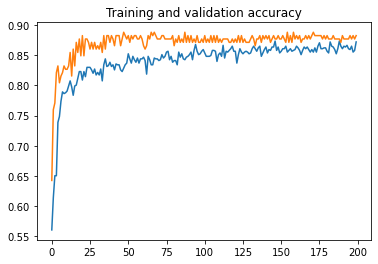

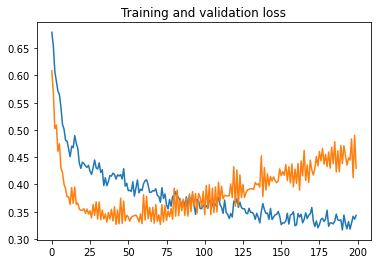

In [165]:
# 에포크에 따른 모델의 변화를 확인. 진동이 심하다는 걸 확인할 수 있다. 
# 파란색이 훈련 데이터, 노란색이 검증 데이터에 대한 정확도, 손실 그래프다

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# 훈련 데이터, 검증 데이터에 대한 에포크당 정확도
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# 훈련 데이터, 검증 데이터에 대한 에포크당 손실률
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )



손실 부분에서 진동이 계속 일어났다.

# 5. 예측하기
<br>
가장 훈련이 잘된 모델로 값을 예측해보자

In [166]:
model.load_weights(filename) # 가장 훈련이 잘된 모델(var_loss기준)을 불러오기

In [167]:
prediction = np.where(model.predict(x_test_np) > 0.5, 1, 0)

In [168]:
prediction.reshape(418)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## csv파일 생성
<br>
에측값과 앞서 저장한 승객 번호를 submission 파일 생성에 사용한다. 

In [169]:
predict_toCsv = {"PassengerId": test_PassengerId, "Survived": prediction}

In [170]:
#csv파일 생성
submission = pd.DataFrame()

submission['PassengerId'] = 0
submission['Survived'] = 0

submission['PassengerId'] = predict_toCsv["PassengerId"]
submission['Survived'] = predict_toCsv["Survived"]

In [178]:
submission.to_csv('submission.csv', index=False) # 파일 저장